In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
import pymc
#from scipy.special import gamma as GammaFunction
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import seaborn as sns
import itertools
import os.path
import attila_utils
import mwm
from cellbayesassay import idatas_to_netcdf

In [2]:
treatments_CO26990 = {
    'A': 'Saline WT',
    'B': 'Saline TG',
    'C': 'Amiloride TG',
}

treatments_CO28152 = {
    'A': 'Amiloride TG',
    'B': 'HCQ TG',
    'C': 'HCQ nano TG',
    'D': 'Saline TG',
    'E': 'R-HCQ TG',
    'F': 'S-HCQ TG',
    'G': 'TUDCA TG',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}

treatments_CO28154 = {
    'A': 'Saline TG',
    #'B': 'Amiloride + HCQ TG', # absent from data
    'C': 'TUDCA + HCQ TG',
    'D': 'Arundine low dose TG',
    'E': 'Arundine mid dose TG',
    'F': 'Arundine high dose TG',
    'G': 'Vehicle (Arundine) TG',
    'H': 'Arundine high dose WT',
    #'I': 'Amiloride + HCQ WT', # absent from data
    'J': 'TUDCA + HCQ WT',
    'K': 'Saline WT',
    'L': 'Vehicle (Arundine) WT',
}


fpath_CO26990 = '../../resources/QPS/5xFAD-mouse/CO26990-behavioral-data-cleaned.xlsx'
fpath_CO28152 = '../../resources/QPS/5xFAD-mouse/CO28152-behavioral-data-cleaned.xlsx'
fpath_CO28154 = '../../resources/QPS/5xFAD-mouse/CO28154-behavioral-data-cleaned.xlsx'

fpathl = [fpath_CO26990, fpath_CO28152, fpath_CO28154]
treatmentsl = [treatments_CO26990, treatments_CO28152, treatments_CO28154]
sheet_namel = ['rawdata MWM day 1-4', 'rawdata MWM day 1-4', 'MWM day 1-4']

Z = zip(fpathl, treatmentsl, sheet_namel)

data_CO26990, data_CO28152, data_CO28154 = [mwm.read_data_train(f, t, sheet_name=s) for f, t, s in Z]
# male only datasets
data_CO26990_m, data_CO28152_m, data_CO28154_m = [df.loc[df['Sex'] == 'm'] for df in [data_CO26990, data_CO28152, data_CO28154]]
data_CO28154.head()

/Users/jonesa7/CTNS/notebooks/src/mwm.py:64: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_train = data_train.stack(level=1)
/Users/jonesa7/CTNS/notebooks/src/mwm.py:64: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_train = data_train.stack(level=1)
/Users/jonesa7/CTNS/notebooks/src/mwm.py:64: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_train = 

Latency  Distance (cm)  Velocity (cm/s)  \
cohort group sex irn   day                                              
II     A     f   15721 Day 1    52.74     1015.22075        19.086425   
                       Day 2    60.08     1088.82750        18.147125   
                       Day 3    50.68      915.51800        16.998050   
                       Day 4    42.36      683.79500        14.696975   
                 15725 Day 1    54.10      994.20225        18.210400   

                              Thigmotaxis  Floating Cohort Group Sex    IRN  \
cohort group sex irn   day                                                    
II     A     f   15721 Day 1    41.474975  1.507714     II     A   f  15721   
                       Day 2    58.022650  0.499334     II     A   f  15721   
                       Day 3    37.496623  3.224045     II     A   f  15721   
                       Day 4    17.884725  4.353538     II     A   f  15721   
                 15725 Day 1    52.676225  1.860057     II     A   f  15725   

                              Day  Condition Status  
cohort group sex irn   day                           
II     A     f   15721 Day 1  1.0  Saline TG   none  
                       Day 2  2.0  Saline TG  right  
                       Day 3  3.0  Saline TG   none  
                       Day 4  4.0  Saline TG   none  
                 15725 Day 1  1.0  Saline TG   none

In [3]:
plotd_CO26990 = {
    'Amiloride 10 TG': (data_CO26990, ['Saline TG', 'Amiloride TG', 'Saline WT']),
}

<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/4144385537.py:3: SyntaxWarning: invalid escape sequence '\W'
  bname = 'latency-' + re.sub('\W+', '-', k)


latency-Amiloride-10-TG


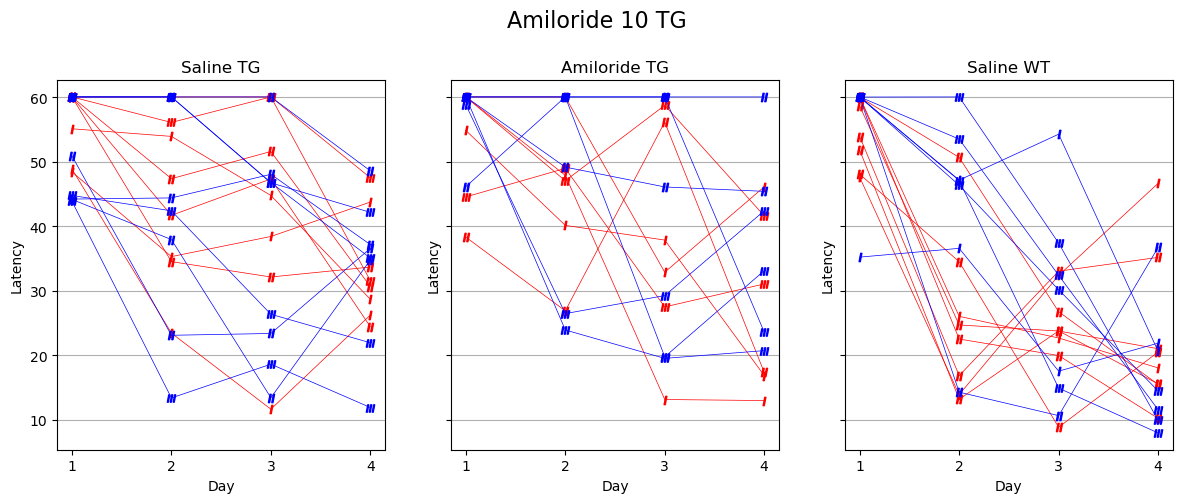

In [4]:
for k, v in plotd_CO26990.items():
    fig, ax = mwm.escape_latency_plotter(k, *v)
    bname = 'latency-' + re.sub('\W+', '-', k)
    print(bname)
    attila_utils.savefig(fig, bname)

In [5]:
plotd_CO28152 = {
    'Amiloride 12 TG': (data_CO28152, ['Saline TG', 'Amiloride TG', 'Saline WT']),
    'HCQ TG': (data_CO28152, ['Saline TG', 'HCQ TG', 'Saline WT']),
    'HCQ nano TG': (data_CO28152, ['Saline TG', 'HCQ nano TG', 'Saline WT']),
    'R-HCQ TG': (data_CO28152, ['Saline TG', 'R-HCQ TG', 'Saline WT']),
    'S-HCQ TG': (data_CO28152, ['Saline TG', 'S-HCQ TG', 'Saline WT']),
    'TUDCA TG': (data_CO28152, ['Saline TG', 'TUDCA TG', 'Saline WT']),
    'TUDCA WT': (data_CO28152, ['Saline WT', 'TUDCA WT', 'DMSO WT']),
}

<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3242005569.py:3: SyntaxWarning: invalid escape sequence '\W'
  bname = 'latency-' + re.sub('\W+', '-', k)


latency-Amiloride-12-TG
latency-HCQ-TG
latency-HCQ-nano-TG
latency-R-HCQ-TG
latency-S-HCQ-TG
latency-TUDCA-TG
latency-TUDCA-WT


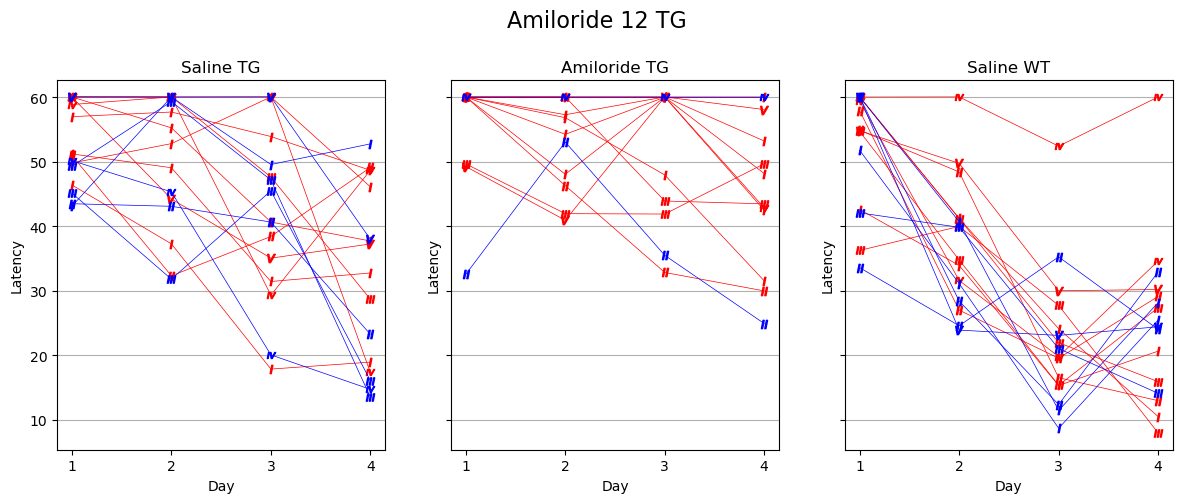

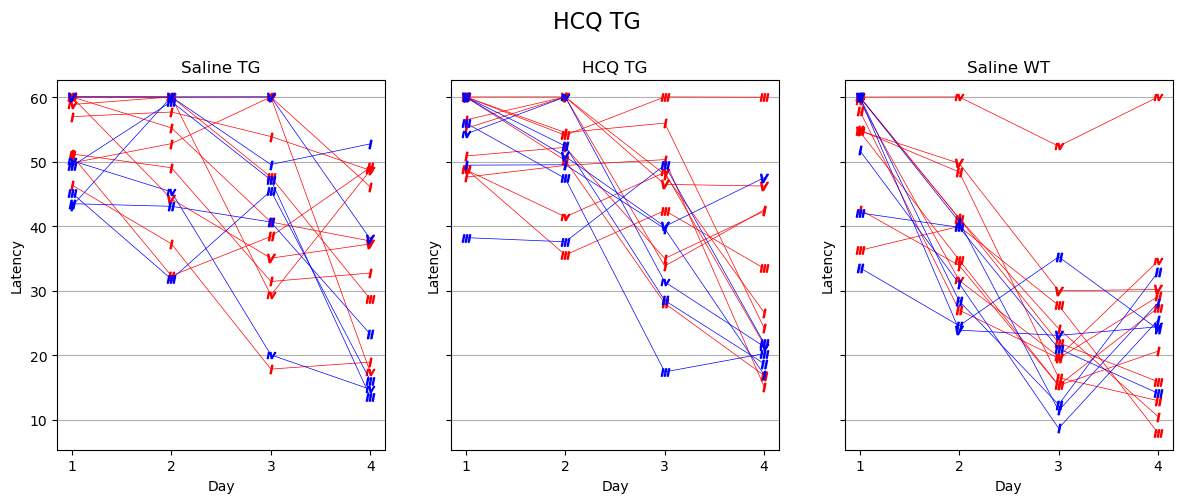

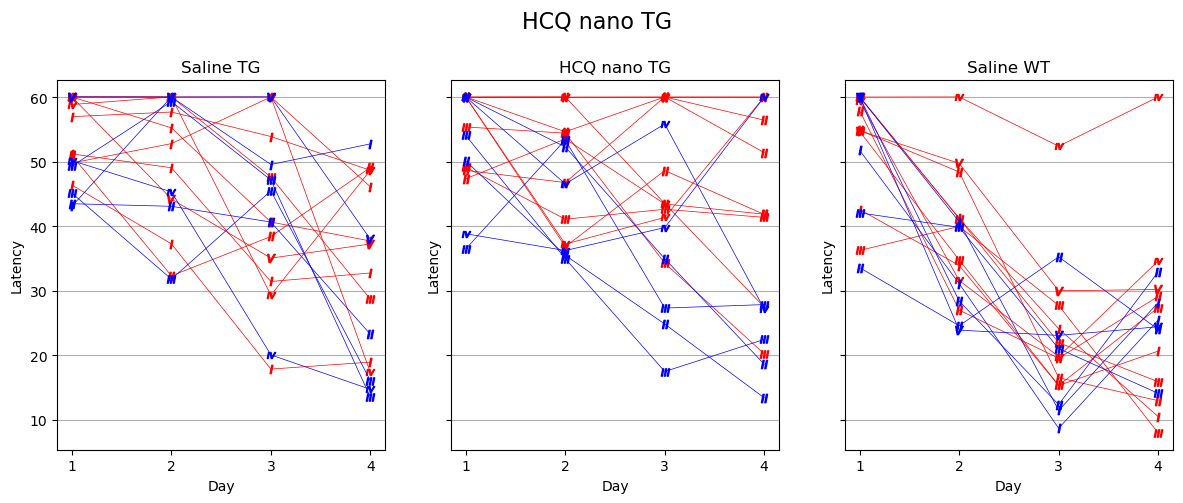

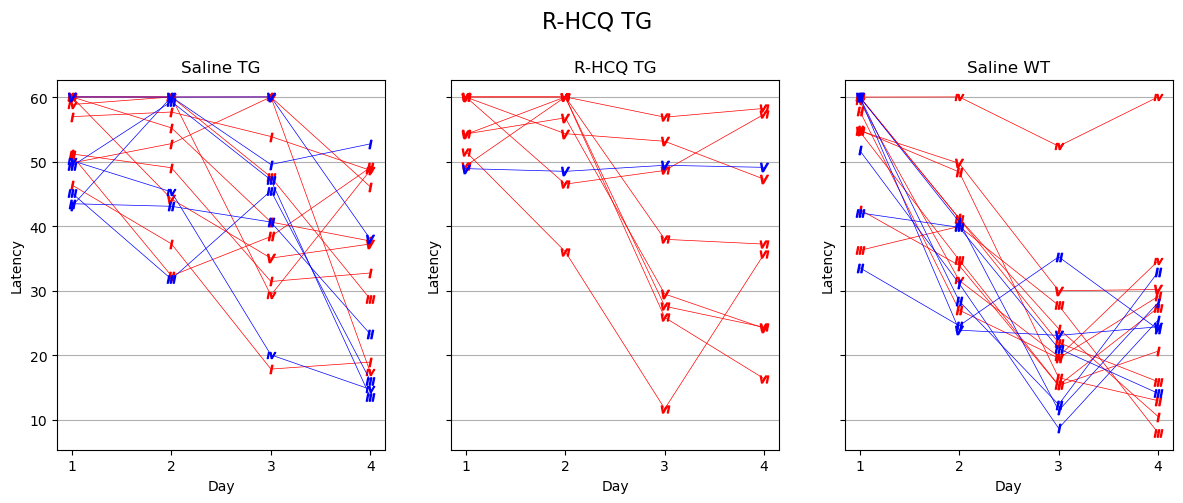

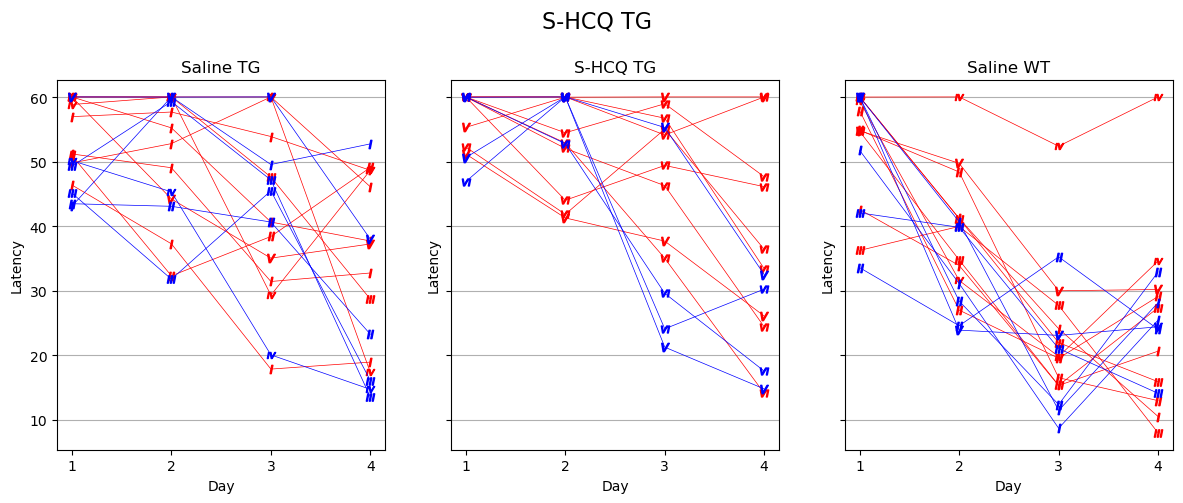

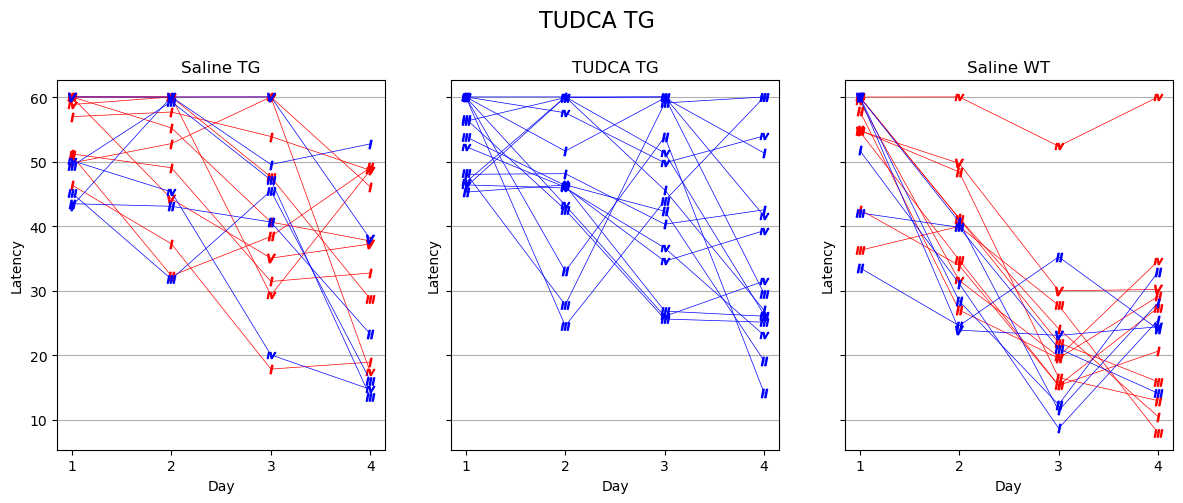

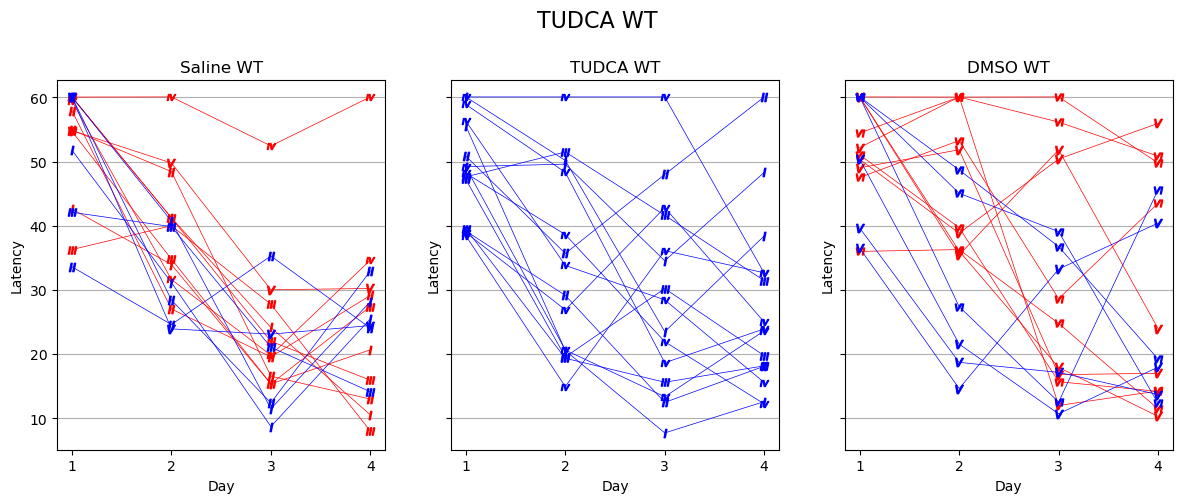

In [6]:
for k, v in plotd_CO28152.items():
    fig, ax = mwm.escape_latency_plotter(k, *v)
    bname = 'latency-' + re.sub('\W+', '-', k)
    print(bname)
    attila_utils.savefig(fig, bname)

In [7]:
plotd_CO28154 = {
    #'Amiloride + HCQ TG': (data_CO28154, ['Saline TG', 'Amiloride + HCQ TG', 'Saline WT']), # absent from data
    'TUDCA + HCQ TG': (data_CO28154, ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT']),
    'Arundine low dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine low dose TG', 'Vehicle (Arundine) WT']),
    'Arundine mid dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine mid dose TG', 'Vehicle (Arundine) WT']),
    'Arundine high dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine high dose TG', 'Vehicle (Arundine) WT']),
    'Arundine high dose WT': (data_CO28154, ['Vehicle (Arundine) WT', 'Arundine high dose WT', 'Vehicle (Arundine) TG']),
    #'Amiloride + HCQ WT': (data_CO28154, ['Saline WT', 'Amiloride + HCQ WT', 'Saline TG']), # absent from data
    'TUDCA + HCQ WT': (data_CO28154, ['Saline WT', 'TUDCA + HCQ WT', 'Saline TG']),
}


<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3481579634.py:3: SyntaxWarning: invalid escape sequence '\W'
  bname = 'latency-' + re.sub('\W+', '-', k)


latency-TUDCA-HCQ-TG
latency-Arundine-low-dose-TG
latency-Arundine-mid-dose-TG
latency-Arundine-high-dose-TG
latency-Arundine-high-dose-WT
latency-TUDCA-HCQ-WT


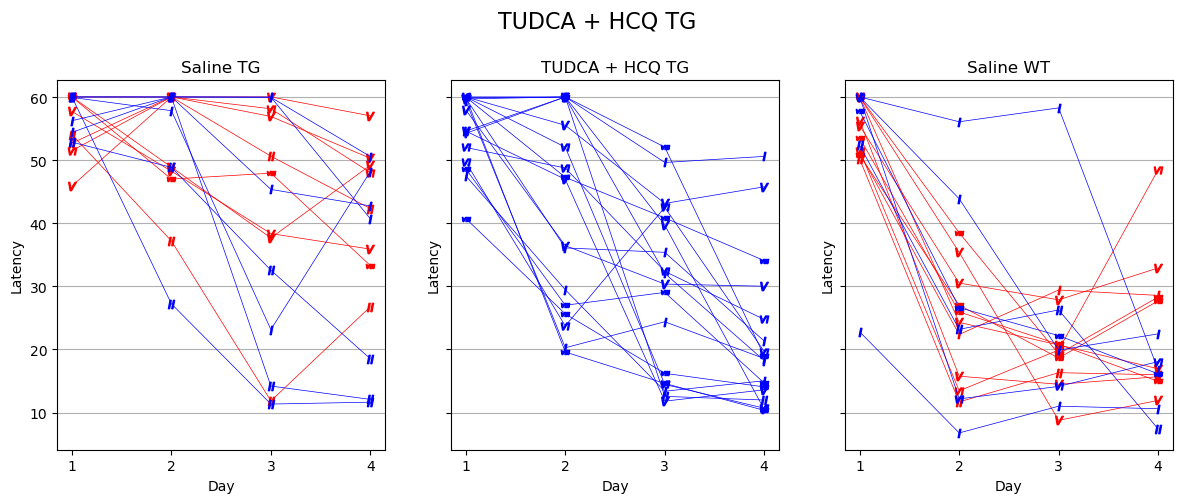

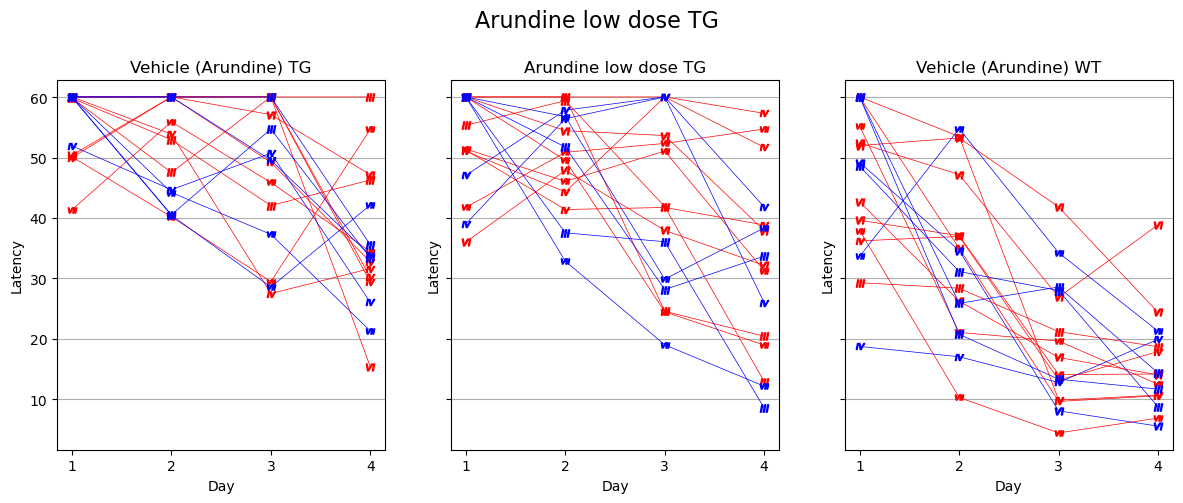

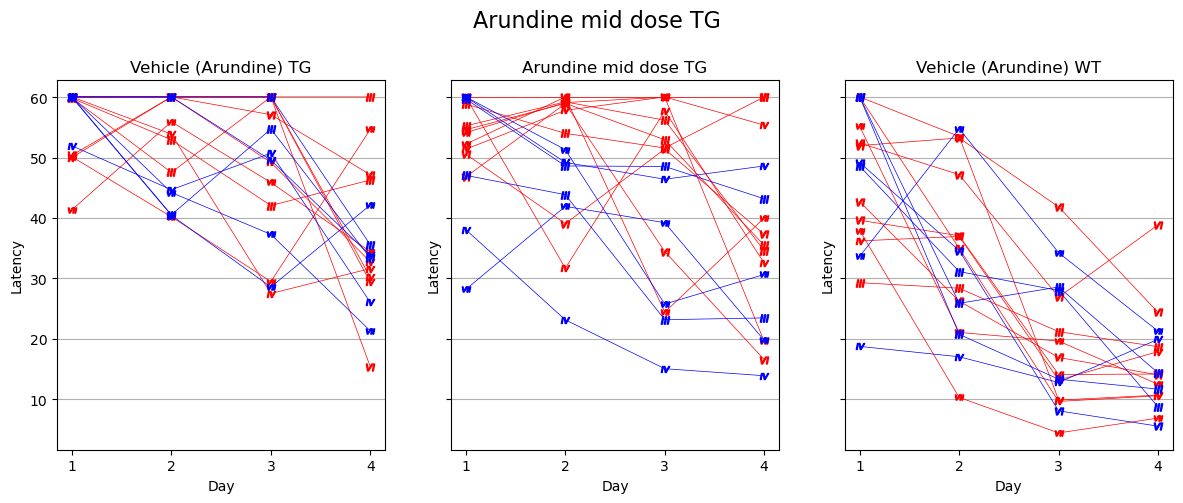

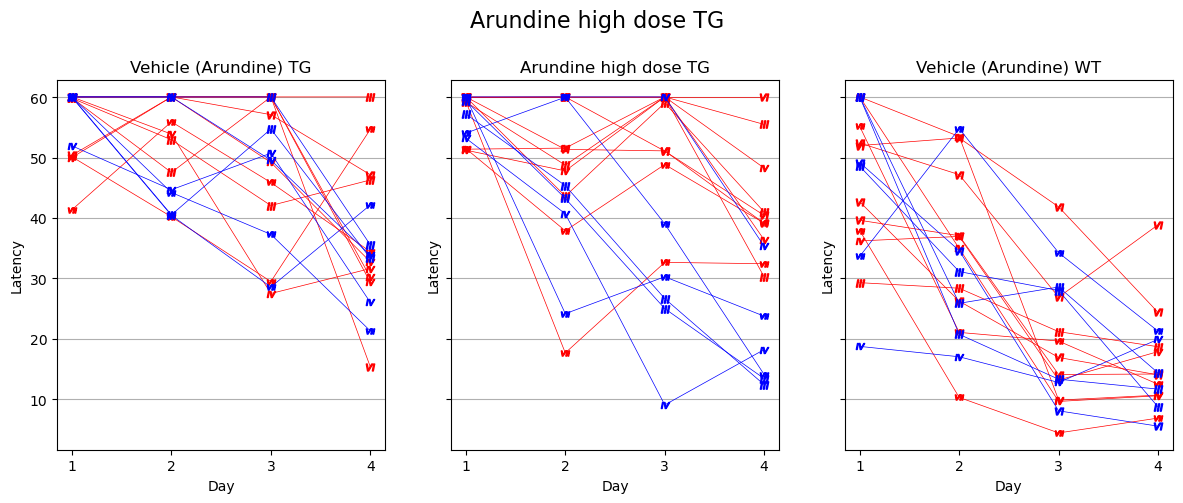

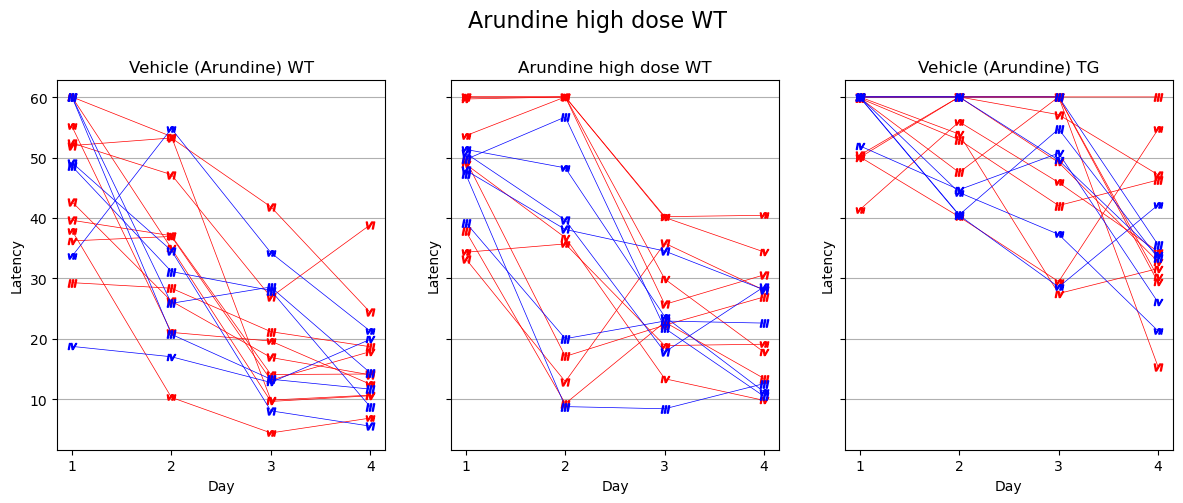

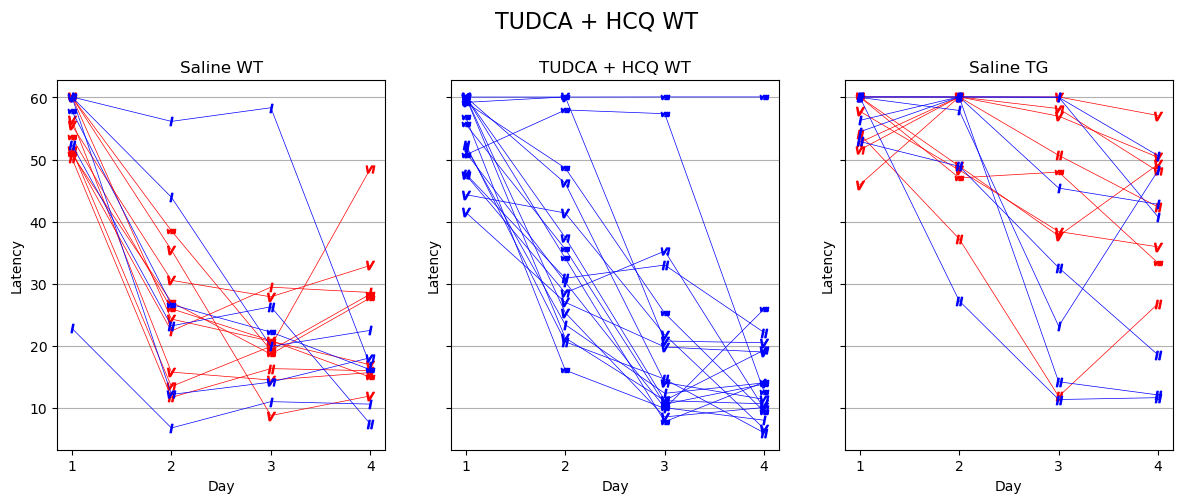

In [8]:
for k, v in plotd_CO28154.items():
    fig, ax = mwm.escape_latency_plotter(k, *v)
    bname = 'latency-' + re.sub('\W+', '-', k)
    print(bname)
    attila_utils.savefig(fig, bname)

## Fit data

In [9]:
def fit_or_read_fitted(experimentsd, subdir, maindir='../../results/2024-06-04-5xfad-behavior-CO28154/'):
    if not os.path.exists(os.path.join(maindir, subdir, 'fpaths.csv')):
        idatas = mwm.fit_multiple(experimentsd)
        fpathdf = idatas_to_netcdf(idatas, subdir, maindir=maindir)
        print('idatas written to netcdf')
    else:
        idatas = mwm.idatas_from_netcdf(subdir=subdir, maindir=maindir)
        print('idatas read from netcdf')
    return(idatas)

seedl = [21947, 21949, 21976, 22021]

In [10]:
experiments3_CO26990 = {
    'Amiloride 10 TG': (data_CO26990, ['Saline TG', 'Amiloride TG', 'Saline WT'], seedl),
}
idatas3_CO26990 = fit_or_read_fitted(experiments3_CO26990, 'idatas3_CO26990', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [11]:
experiments3_CO26990_m = {
    'Amiloride 10 TG': (data_CO26990_m, ['Saline TG', 'Amiloride TG', 'Saline WT'], seedl),
}
idatas3_CO26990_m = fit_or_read_fitted(experiments3_CO26990_m, 'idatas3_CO26990_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [12]:
experiments2_CO26990 = {
    'WT': (data_CO28152, ['Saline TG', 'Saline WT'], seedl),
    'Amiloride 10 TG': (data_CO26990, ['Saline TG', 'Amiloride TG'], seedl),
}
idatas2_CO26990 = fit_or_read_fitted(experiments2_CO26990, 'idatas2_CO26990', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [13]:
experiments2_CO26990_m = {
    'WT': (data_CO28152, ['Saline TG', 'Saline WT'], seedl),
    'Amiloride 10 TG': (data_CO26990_m, ['Saline TG', 'Amiloride TG'], seedl),
}
idatas2_CO26990_m = fit_or_read_fitted(experiments2_CO26990_m, 'idatas2_CO26990_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [14]:
experiments3_CO28152 = {
    'Amiloride 12 TG': (data_CO28152, ['Saline TG', 'Amiloride TG', 'Saline WT'], seedl),
    'HCQ TG': (data_CO28152, ['Saline TG', 'HCQ TG', 'Saline WT'], seedl),
    'HCQ nano TG': (data_CO28152, ['Saline TG', 'HCQ nano TG', 'Saline WT'], seedl),
    'R-HCQ TG': (data_CO28152, ['Saline TG', 'R-HCQ TG', 'Saline WT'], seedl),
    'S-HCQ TG': (data_CO28152, ['Saline TG', 'S-HCQ TG', 'Saline WT'], seedl),
    'TUDCA TG': (data_CO28152, ['Saline TG', 'TUDCA TG', 'Saline WT'], seedl),
    'TUDCA WT': (data_CO28152, ['Saline WT', 'TUDCA TG', 'Saline TG'], seedl),
}
idatas3_CO28152 = fit_or_read_fitted(experiments3_CO28152, 'idatas3_CO28152', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [15]:
experiments3_CO28152_m = {
    'Amiloride 12 TG': (data_CO28152_m, ['Saline TG', 'Amiloride TG', 'Saline WT'], seedl),
    'HCQ TG': (data_CO28152_m, ['Saline TG', 'HCQ TG', 'Saline WT'], seedl),
    'HCQ nano TG': (data_CO28152_m, ['Saline TG', 'HCQ nano TG', 'Saline WT'], seedl),
    'R-HCQ TG': (data_CO28152_m, ['Saline TG', 'R-HCQ TG', 'Saline WT'], seedl),
    'S-HCQ TG': (data_CO28152_m, ['Saline TG', 'S-HCQ TG', 'Saline WT'], seedl),
    'TUDCA TG': (data_CO28152_m, ['Saline TG', 'TUDCA TG', 'Saline WT'], seedl),
    'TUDCA WT': (data_CO28152_m, ['Saline WT', 'TUDCA TG', 'Saline TG'], seedl),
}
idatas3_CO28152_m = fit_or_read_fitted(experiments3_CO28152_m, 'idatas3_CO28152_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [16]:
experiments2_CO28152 = {
    'WT': (data_CO28152, ['Saline TG', 'Saline WT'], seedl),
    'Amiloride 12 TG': (data_CO28152, ['Saline TG', 'Amiloride TG'], seedl),
    'HCQ TG': (data_CO28152, ['Saline TG', 'HCQ TG'], seedl),
    'HCQ nano TG': (data_CO28152, ['Saline TG', 'HCQ nano TG'], seedl),
    'R-HCQ TG': (data_CO28152, ['Saline TG', 'R-HCQ TG'], seedl),
    'S-HCQ TG': (data_CO28152, ['Saline TG', 'S-HCQ TG'], seedl),
    'TUDCA TG': (data_CO28152, ['Saline TG', 'TUDCA TG'], seedl),
    'TUDCA WT': (data_CO28152, ['Saline WT', 'TUDCA TG'], seedl),
}
idatas2_CO28152 = fit_or_read_fitted(experiments2_CO28152, 'idatas2_CO28152', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [17]:
experiments2_CO28152_m = {
    'WT': (data_CO28152_m, ['Saline TG', 'Saline WT'], seedl),
    'Amiloride 12 TG': (data_CO28152_m, ['Saline TG', 'Amiloride TG'], seedl),
    'HCQ TG': (data_CO28152_m, ['Saline TG', 'HCQ TG'], seedl),
    'HCQ nano TG': (data_CO28152_m, ['Saline TG', 'HCQ nano TG'], seedl),
    'R-HCQ TG': (data_CO28152_m, ['Saline TG', 'R-HCQ TG'], seedl),
    'S-HCQ TG': (data_CO28152_m, ['Saline TG', 'S-HCQ TG'], seedl),
    'TUDCA TG': (data_CO28152_m, ['Saline TG', 'TUDCA TG'], seedl),
    'TUDCA WT': (data_CO28152_m, ['Saline WT', 'TUDCA TG'], seedl),
}
idatas2_CO28152_m = fit_or_read_fitted(experiments2_CO28152_m, 'idatas2_CO28152_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [18]:
experiments_CO28152 = {
    'CO28152 TG': (data_CO28152,
            [
                'Saline TG',
                'Amiloride TG',
                'HCQ TG',
                'HCQ nano TG',
                'R-HCQ TG',
                'S-HCQ TG',
                'TUDCA TG',
                'Saline WT',
                ], seedl),
    'CO28152 WT': (data_CO28152, ['Saline WT', 'TUDCA WT'], seedl),
}
idatas_CO28152 = fit_or_read_fitted(experiments_CO28152, 'idatas_CO28152', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [19]:
experiments_CO28152_m = {
    'CO28152 TG': (data_CO28152_m,
            [
                'Saline TG',
                'Amiloride TG',
                'HCQ TG',
                'HCQ nano TG',
                'R-HCQ TG',
                'S-HCQ TG',
                'TUDCA TG',
                'Saline WT',
                ], seedl),
    'CO28152 WT': (data_CO28152_m, ['Saline WT', 'TUDCA WT'], seedl),
}
idatas_CO28152_m = fit_or_read_fitted(experiments_CO28152_m, 'idatas_CO28152_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [20]:
experiments3_CO28154 = {
    'TUDCA + HCQ TG': (data_CO28154, ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT'], seedl),
    'Arundine low dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine low dose TG', 'Vehicle (Arundine) WT'], seedl),
    'Arundine mid dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine mid dose TG', 'Vehicle (Arundine) WT'], seedl),
    'Arundine high dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine high dose TG', 'Vehicle (Arundine) WT'], seedl),
    'Arundine high dose WT': (data_CO28154, ['Vehicle (Arundine) WT', 'Arundine high dose WT', 'Vehicle (Arundine) TG'], seedl),
    'TUDCA + HCQ WT': (data_CO28154, ['Saline WT', 'TUDCA + HCQ WT', 'Saline TG'], seedl),
}
idatas3_CO28154 = fit_or_read_fitted(experiments3_CO28154, 'idatas3_CO28154', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [21]:
experiments3_CO28154_m = {
    'TUDCA + HCQ TG': (data_CO28154_m, ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT'], seedl),
    'Arundine low dose TG': (data_CO28154_m, ['Vehicle (Arundine) TG', 'Arundine low dose TG', 'Vehicle (Arundine) WT'], seedl),
    'Arundine mid dose TG': (data_CO28154_m, ['Vehicle (Arundine) TG', 'Arundine mid dose TG', 'Vehicle (Arundine) WT'], seedl),
    'Arundine high dose TG': (data_CO28154_m, ['Vehicle (Arundine) TG', 'Arundine high dose TG', 'Vehicle (Arundine) WT'], seedl),
    'Arundine high dose WT': (data_CO28154_m, ['Vehicle (Arundine) WT', 'Arundine high dose WT', 'Vehicle (Arundine) TG'], seedl),
    'TUDCA + HCQ WT': (data_CO28154_m, ['Saline WT', 'TUDCA + HCQ WT', 'Saline TG'], seedl),
}
idatas3_CO28154_m = fit_or_read_fitted(experiments3_CO28154_m, 'idatas3_CO28154_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [22]:
experiments2_CO28154 = {
    'WT': (data_CO28154, ['Saline TG', 'Saline WT'], seedl),
    'TUDCA + HCQ TG': (data_CO28154, ['Saline TG', 'TUDCA + HCQ TG'], seedl),
    'Arundine low dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine low dose TG'], seedl),
    'Arundine mid dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine mid dose TG'], seedl),
    'Arundine high dose TG': (data_CO28154, ['Vehicle (Arundine) TG', 'Arundine high dose TG'], seedl),
    'Arundine high dose WT': (data_CO28154, ['Vehicle (Arundine) WT', 'Arundine high dose WT'], seedl),
    'TUDCA + HCQ WT': (data_CO28154, ['Saline WT', 'TUDCA + HCQ WT'], seedl),
}
idatas2_CO28154 = fit_or_read_fitted(experiments2_CO28154, 'idatas2_CO28154', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [23]:
experiments2_CO28154_m = {
    'WT': (data_CO28154_m, ['Saline TG', 'Saline WT'], seedl),
    'TUDCA + HCQ TG': (data_CO28154_m, ['Saline TG', 'TUDCA + HCQ TG'], seedl),
    'Arundine low dose TG': (data_CO28154_m, ['Vehicle (Arundine) TG', 'Arundine low dose TG'], seedl),
    'Arundine mid dose TG': (data_CO28154_m, ['Vehicle (Arundine) TG', 'Arundine mid dose TG'], seedl),
    'Arundine high dose TG': (data_CO28154_m, ['Vehicle (Arundine) TG', 'Arundine high dose TG'], seedl),
    'Arundine high dose WT': (data_CO28154_m, ['Vehicle (Arundine) WT', 'Arundine high dose WT'], seedl),
    'TUDCA + HCQ WT': (data_CO28154_m, ['Saline WT', 'TUDCA + HCQ WT'], seedl),
}
idatas2_CO28154_m = fit_or_read_fitted(experiments2_CO28154_m, 'idatas2_CO28154_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [24]:
experiments_CO28154 = {
    'TUDCA + HCQ TG': (data_CO28154,
                    [
                        'Saline TG',
                        'TUDCA + HCQ TG',
                        'Saline WT',
                    ], seedl),
    'Arundine TG': (data_CO28154,
                 [
                     'Vehicle (Arundine) TG',
                     'Arundine low dose TG',
                     'Arundine mid dose TG',
                     'Arundine high dose TG',
                     'Vehicle (Arundine) WT'
                 ], seedl),
    'TUDCA + HCQ WT': (data_CO28154,
                    [
                        'Saline WT',
                        'TUDCA + HCQ WT',
                    ], seedl),
    'Arundine WT': (data_CO28154,
                 [
                     'Vehicle (Arundine) WT',
                     'Arundine high dose WT',
                 ], seedl),
}
idatas_CO28154 = fit_or_read_fitted(experiments_CO28154, 'idatas_CO28154', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


In [25]:
experiments_CO28154_m = {
    'TUDCA + HCQ TG': (data_CO28154_m,
                    [
                        'Saline TG',
                        'TUDCA + HCQ TG',
                        'Saline WT',
                    ], seedl),
    'Arundine TG': (data_CO28154_m,
                 [
                     'Vehicle (Arundine) TG',
                     'Arundine low dose TG',
                     'Arundine mid dose TG',
                     'Arundine high dose TG',
                     'Vehicle (Arundine) WT'
                 ], seedl),
    'TUDCA + HCQ WT': (data_CO28154_m,
                    [
                        'Saline WT',
                        'TUDCA + HCQ WT',
                    ], seedl),
    'Arundine WT': (data_CO28154_m,
                 [
                     'Vehicle (Arundine) WT',
                     'Arundine high dose WT',
                 ], seedl),
}
idatas_CO28154_m = fit_or_read_fitted(experiments_CO28154_m, 'idatas_CO28154_m', maindir='../../results/2024-06-04-5xfad-behavior-CO28154/')

idatas read from netcdf


## MCMC diagnostics

### idatas3_CO28154

In [26]:
mwm.get_diagnostics(idatas_CO28152, az.ess)

In [27]:
mwm.get_diagnostics(idatas2_CO28152, az.ess)

In [28]:
mwm.get_diagnostics(idatas_CO28152, az.rhat)

In [29]:
mwm.get_diagnostics(idatas2_CO28152, az.rhat)

In [30]:
mwm.get_diagnostics(idatas_CO28152, az.mcse)

In [31]:
mwm.get_diagnostics(idatas2_CO28152, az.mcse)

## Sampled curves

In [32]:
def model_escape_latency_plotter_ax(axi, idata, level='Saline WT', ref_lvl='Saline TG', color='yellow', log_yscale=False):
    chain = 0
    xx = np.linspace(1, 4, 201)
    summary = az.summary(idata)
    for i in np.arange(0, idata.posterior.dims['draw'], step=4):
        Intercept = idata.posterior['Intercept'][chain][i].to_numpy()
        Day = idata.posterior['Day'][chain][i].to_numpy()
        Condition = idata.posterior['C(Condition, levels=lvl)'][chain][i].to_numpy()
        Condition = [0] + list(Condition)
        prefix = '^C\(Condition, levels=lvl\)\['
        ix = [re.sub(prefix + '(.*)\]$','\\1', x) for x in summary.index if re.match(prefix + '.*$', x)]
        ix = [ref_lvl] + ix
        s_Condition = pd.Series(Condition, index=ix)
        s_Condition = s_Condition.loc[level]
        yy = np.exp(Intercept + s_Condition + Day * xx)
        yy = [min(y, 60) for y in yy]
        axi.plot(xx, yy, linewidth=1, color=color, alpha=0.05)
    Intercept = summary.loc['Intercept', 'mean']
    Day = summary.loc['Day', 'mean']
    if level == ref_lvl:
        cond = 0
    else:
        cond = summary.loc['C(Condition, levels=lvl)[' + level + ']', 'mean']
    yy = np.exp(Intercept + cond + Day * xx)
    yy = [min(y, 60) for y in yy]
    axi.plot(xx, yy, linewidth=4, color=color, label=level)
    #axi.plot(xx, yy, linewidth=4, color='white', linestyle='dotted')
    if log_yscale:
        axi.set_yscale('log')
    axi.grid(visible=True, axis='y', which='both')
    axi.set_ylim(15 if log_yscale else 0, 65)
    return(axi)

<>:10: SyntaxWarning: invalid escape sequence '\('
<>:11: SyntaxWarning: invalid escape sequence '\]'
<>:10: SyntaxWarning: invalid escape sequence '\('
<>:11: SyntaxWarning: invalid escape sequence '\]'
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:10: SyntaxWarning: invalid escape sequence '\('
  prefix = '^C\(Condition, levels=lvl\)\['
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:11: SyntaxWarning: invalid escape sequence '\]'
  ix = [re.sub(prefix + '(.*)\]$','\\1', x) for x in summary.index if re.match(prefix + '.*$', x)]


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consi

['named-figure/model-latency-CO28154-TUDCA_HCQ-TG.png',
 'named-figure/model-latency-CO28154-TUDCA_HCQ-TG.pdf']

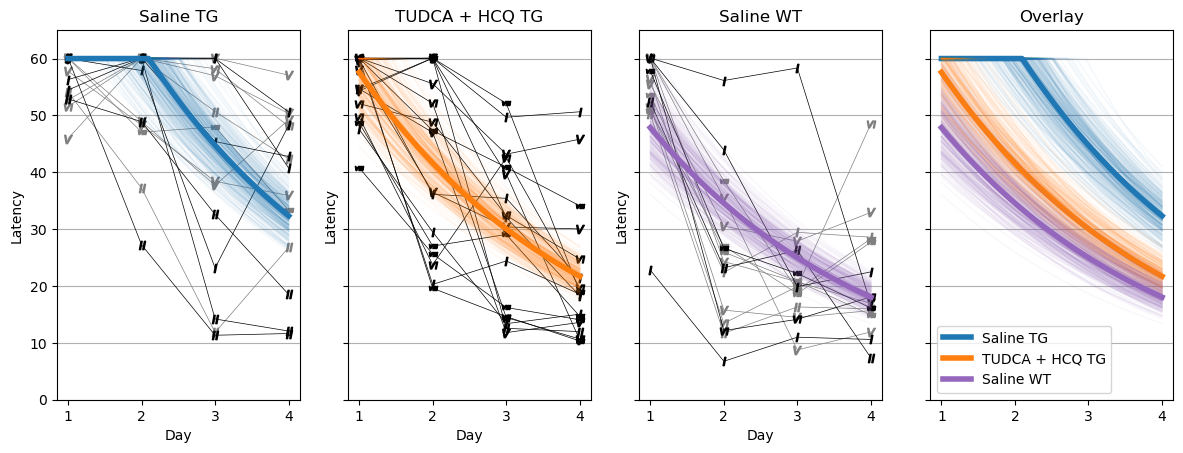

In [33]:
def model_escape_latency_plotter(idata, data, lvl=['Saline TG', 'TUDCA + HCQ TG', 'Saline WT'], colors=['C0', 'C1', 'C4'], ref_lvl='Saline TG', log_yscale=False, exper=''):
    treatment_lvl = lvl.copy()
    treatment_lvl.remove(ref_lvl)
    fig, ax = mwm.escape_latency_plotter(exper, data, lvl=lvl, colors={'f': 'gray', 'm': 'k'}, extra_subplot=True)
    for color, level, axi in zip(colors, lvl, ax[:-1]):
        axi = model_escape_latency_plotter_ax(axi, idata, level, ref_lvl, color, log_yscale)
        model_escape_latency_plotter_ax(ax[-1], idata, level, ref_lvl, color=color)
    ax[-1].set_title('Overlay')
    ax[-1].legend()
    return((fig, ax))

idata = idatas_CO28154.loc['TUDCA + HCQ TG']
lvl = ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT']
fig, ax = model_escape_latency_plotter(idata, data_CO28154, lvl=lvl, ref_lvl='Saline TG', log_yscale=False)
attila_utils.savefig(fig, 'model-latency-CO28154-TUDCA_HCQ-TG')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consi

['named-figure/model-latency-CO28154-TUDCA_HCQ-TG-anonym.png',
 'named-figure/model-latency-CO28154-TUDCA_HCQ-TG-anonym.pdf']

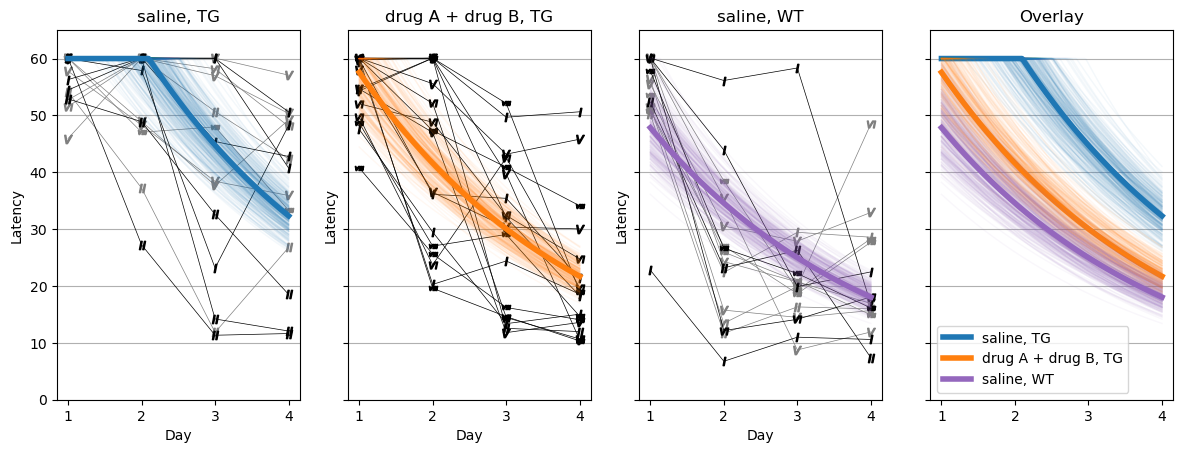

In [34]:
idata = idatas_CO28154.loc['TUDCA + HCQ TG']
lvl = ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT']
lvl_anonym = ['saline, TG', 'drug A + drug B, TG', 'saline, WT']
fig, ax = model_escape_latency_plotter(idata, data_CO28154, lvl=lvl, ref_lvl='Saline TG', log_yscale=False)
for i, title in enumerate(lvl_anonym):
    ax[i].set_title(title)
h, l = ax[-1].get_legend_handles_labels()
ax[-1].legend(h, lvl_anonym)
attila_utils.savefig(fig, 'model-latency-CO28154-TUDCA_HCQ-TG-anonym')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consi

['named-figure/model-latency-CO28154-TUDCA_HCQ-TG_m.png',
 'named-figure/model-latency-CO28154-TUDCA_HCQ-TG_m.pdf']

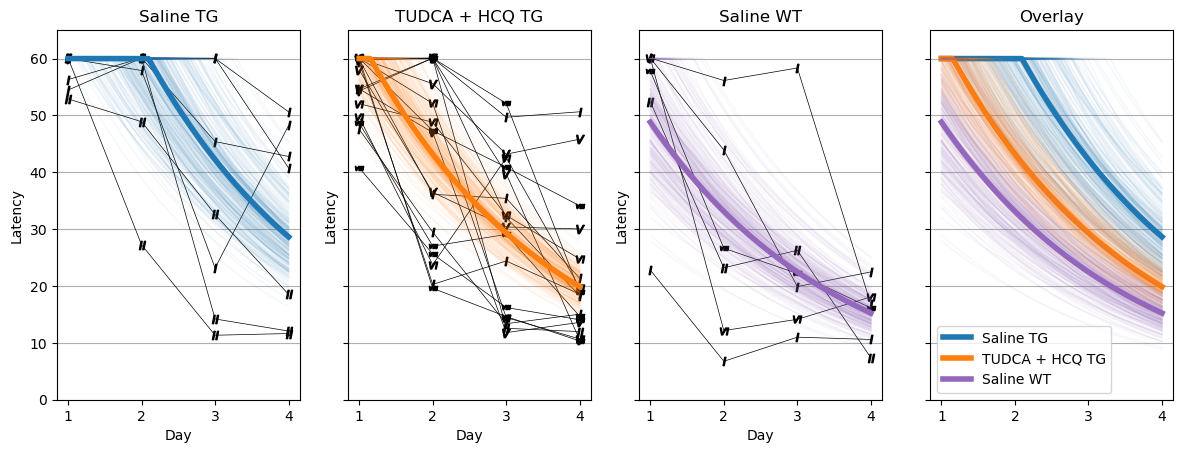

In [35]:
idata = idatas_CO28154_m.loc['TUDCA + HCQ TG']
lvl = ['Saline TG', 'TUDCA + HCQ TG', 'Saline WT']
fig, ax = model_escape_latency_plotter(idata, data_CO28154_m, lvl=lvl, ref_lvl='Saline TG', log_yscale=False)
attila_utils.savefig(fig, 'model-latency-CO28154-TUDCA_HCQ-TG_m')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axi.set_ylim(15 if log_yscale else 0, 65)
/var/fo

['named-figure/model-latency-CO28154-TUDCA_HCQ-TG-log.png',
 'named-figure/model-latency-CO28154-TUDCA_HCQ-TG-log.pdf']

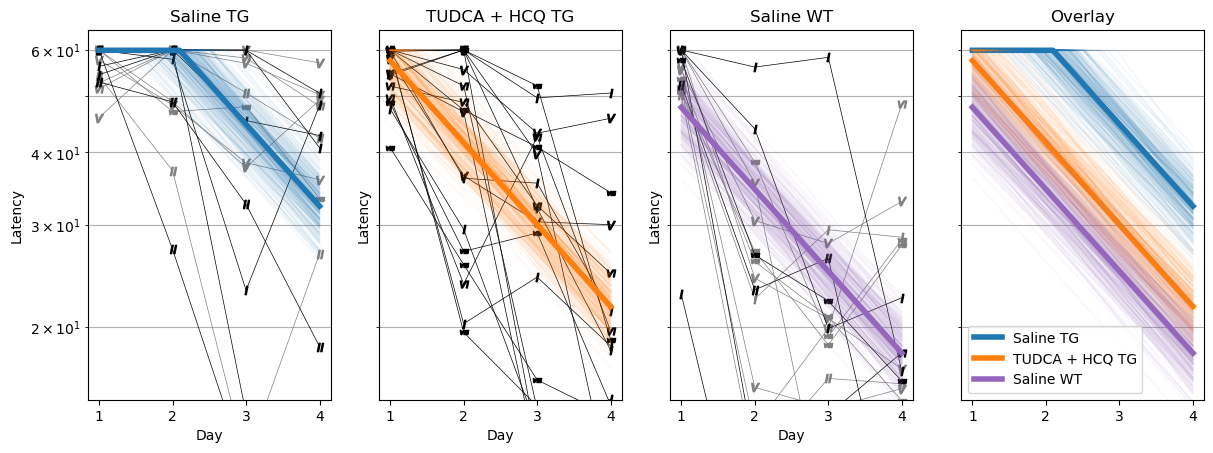

In [36]:
idata = idatas_CO28154.loc['TUDCA + HCQ TG']
fig, ax = model_escape_latency_plotter(idata, data_CO28154, lvl=lvl, ref_lvl='Saline TG', log_yscale=True)
attila_utils.savefig(fig, 'model-latency-CO28154-TUDCA_HCQ-TG-log')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axi.set_ylim(15 if log_yscale else 0, 65)
/var/fo

['named-figure/model-latency-CO28154-TUDCA_HCQ-TG-log_m.png',
 'named-figure/model-latency-CO28154-TUDCA_HCQ-TG-log_m.pdf']

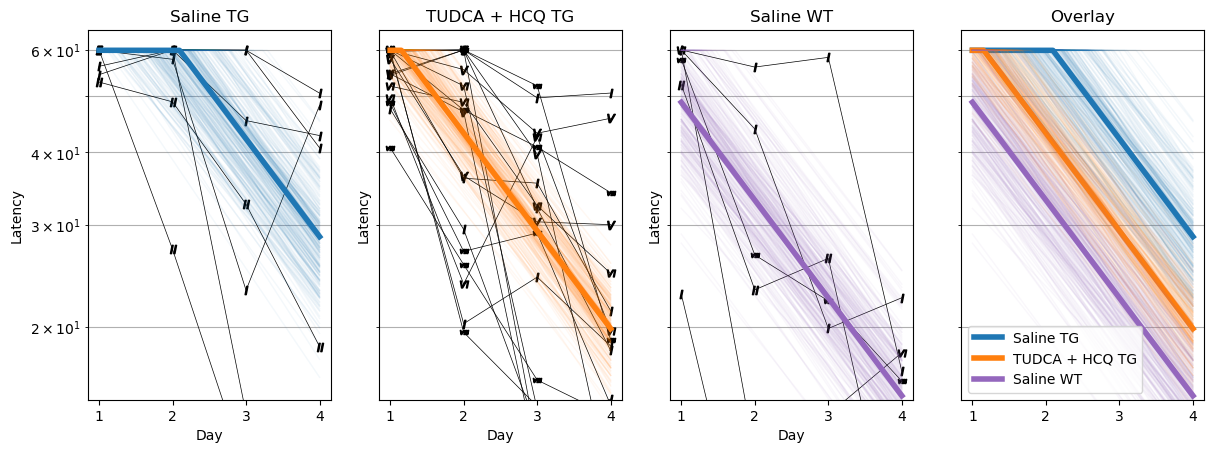

In [37]:
idata = idatas_CO28154_m.loc['TUDCA + HCQ TG']
fig, ax = model_escape_latency_plotter(idata, data_CO28154_m, lvl=lvl, ref_lvl='Saline TG', log_yscale=True)
attila_utils.savefig(fig, 'model-latency-CO28154-TUDCA_HCQ-TG-log_m')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consi

['named-figure/model-latency-CO28152-TUDCA-HCQ-TG.png',
 'named-figure/model-latency-CO28152-TUDCA-HCQ-TG.pdf']

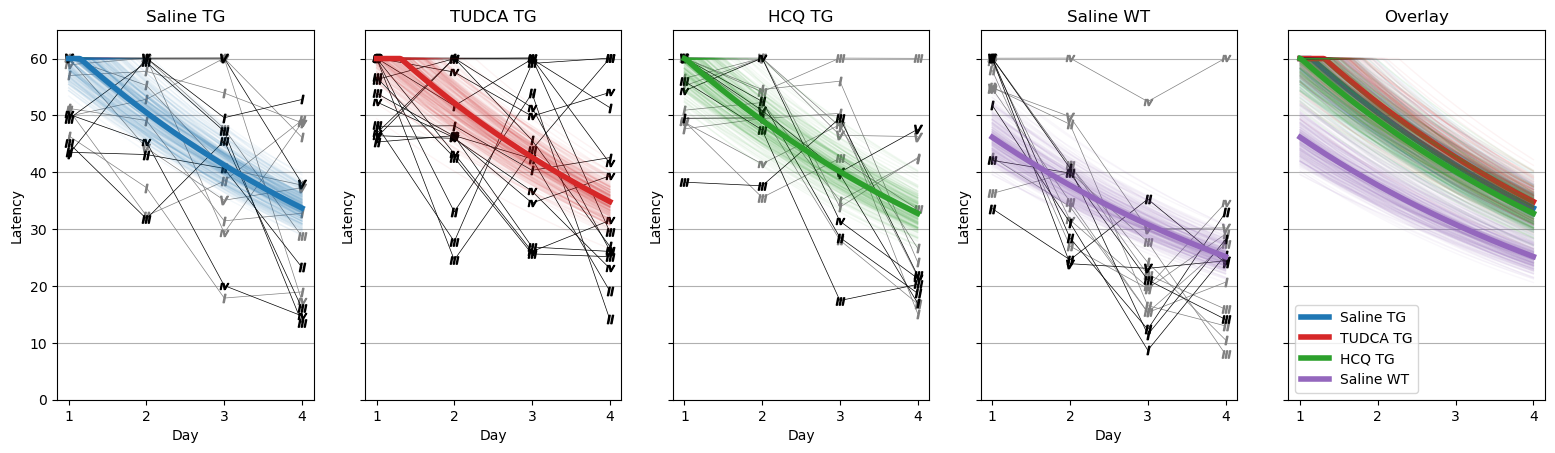

In [38]:
idata = idatas_CO28152.loc['CO28152 TG']
lvl = [
    'Saline TG',
    'TUDCA TG',
    'HCQ TG',
    'Saline WT',
]
colors = ['C0', 'C3', 'C2', 'C4']
fig, ax = model_escape_latency_plotter(idata, data_CO28152, lvl=lvl, ref_lvl='Saline TG', colors=colors, log_yscale=False)
attila_utils.savefig(fig, 'model-latency-CO28152-TUDCA-HCQ-TG')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consi

['named-figure/model-latency-CO28152-TUDCA-HCQ-TG_m.png',
 'named-figure/model-latency-CO28152-TUDCA-HCQ-TG_m.pdf']

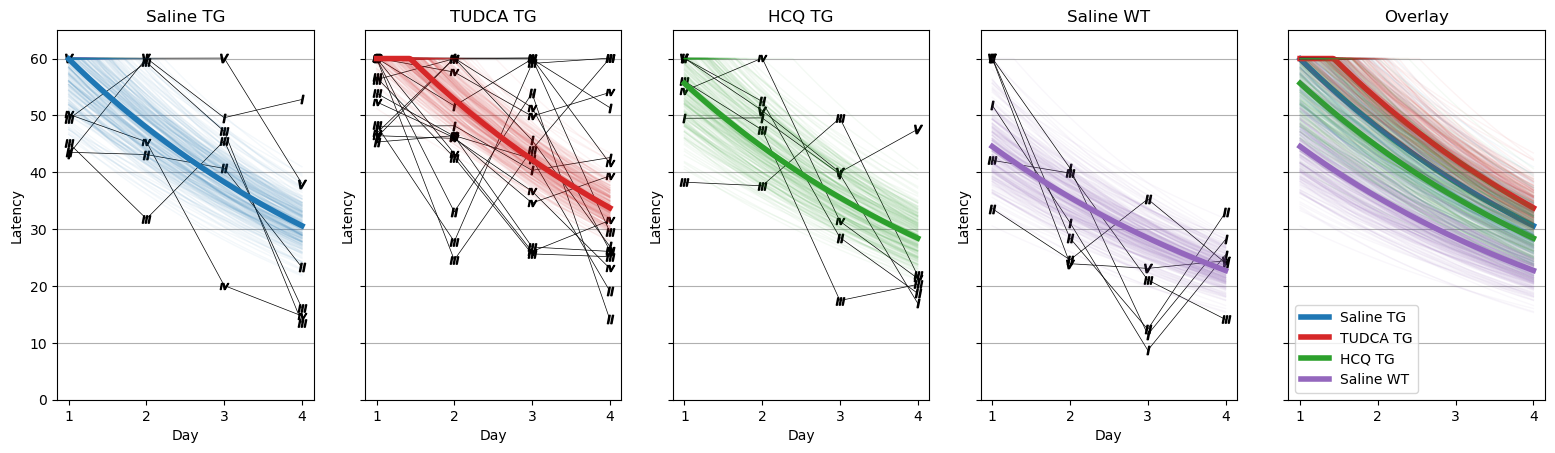

In [39]:
idata = idatas_CO28152_m.loc['CO28152 TG']
lvl = [
    'Saline TG',
    'TUDCA TG',
    'HCQ TG',
    'Saline WT',
]
colors = ['C0', 'C3', 'C2', 'C4']
fig, ax = model_escape_latency_plotter(idata, data_CO28152_m, lvl=lvl, colors=colors, ref_lvl='Saline TG', log_yscale=False)
attila_utils.savefig(fig, 'model-latency-CO28152-TUDCA-HCQ-TG_m')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axi.set_ylim(15 if log_yscale else 0, 65)
/var/fo

['named-figure/model-latency-CO28152-TUDCA-HCQ-TG-log.png',
 'named-figure/model-latency-CO28152-TUDCA-HCQ-TG-log.pdf']

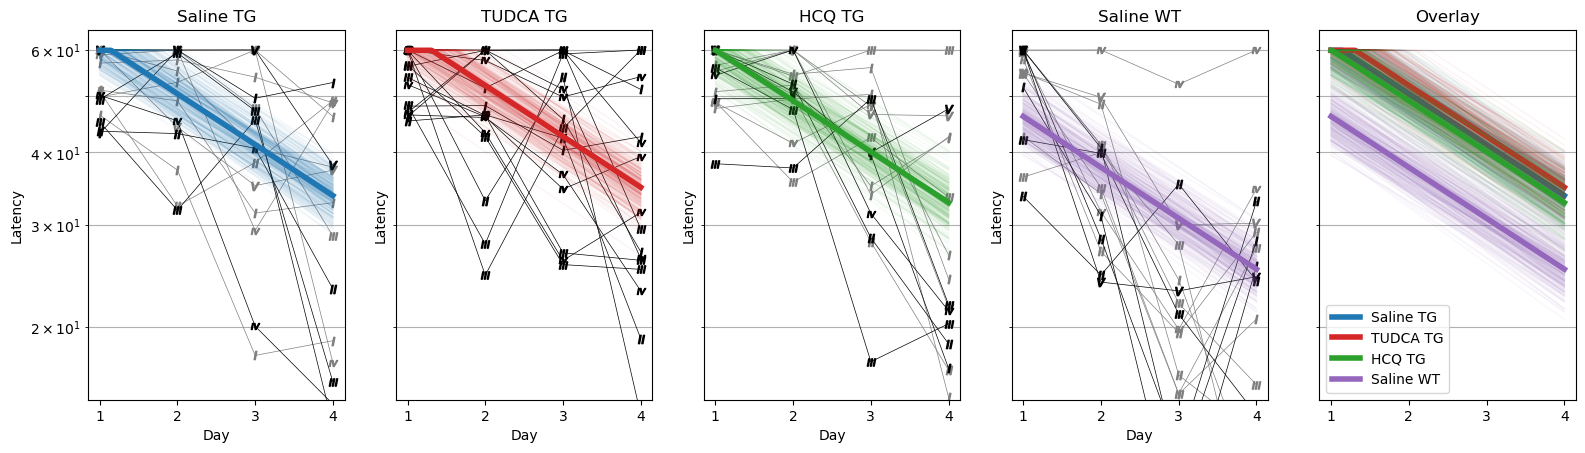

In [40]:
idata = idatas_CO28152.loc['CO28152 TG']
fig, ax = model_escape_latency_plotter(idata, data_CO28152, lvl=lvl, colors=colors, ref_lvl='Saline TG', log_yscale=True)
attila_utils.savefig(fig, 'model-latency-CO28152-TUDCA-HCQ-TG-log')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in np.arange(0, idata.posterior.dims['draw'], step=4):
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/3876404333.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axi.set_ylim(15 if log_yscale else 0, 65)
/var/fo

['named-figure/model-latency-CO28152-TUDCA-HCQ-TG-log_m.png',
 'named-figure/model-latency-CO28152-TUDCA-HCQ-TG-log_m.pdf']

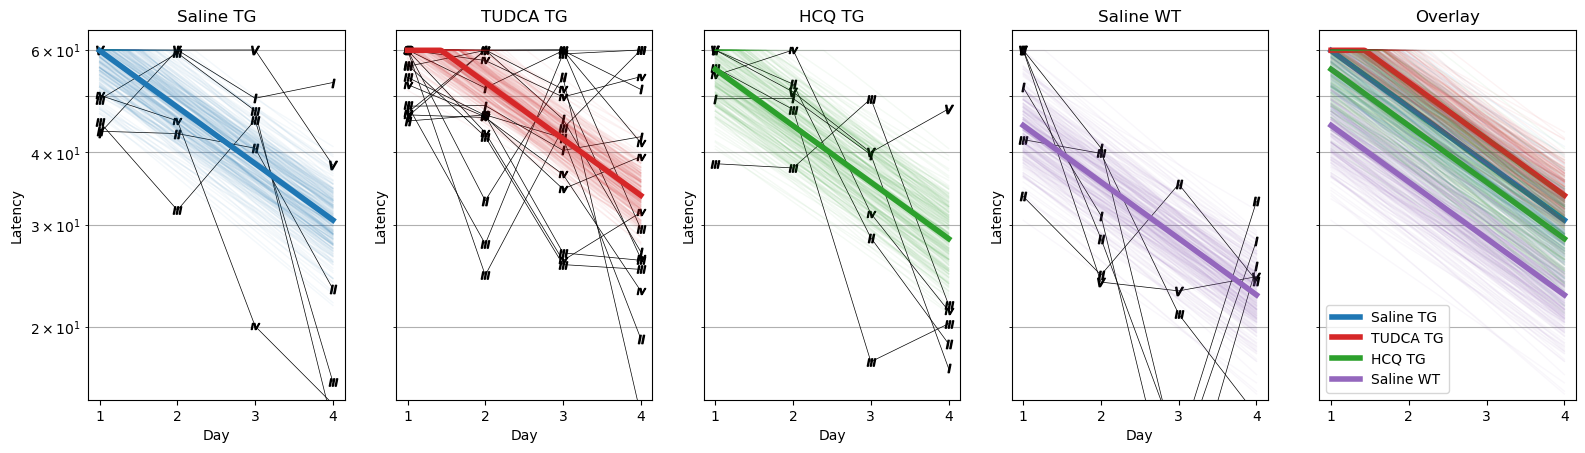

In [41]:
idata = idatas_CO28152_m.loc['CO28152 TG']
fig, ax = model_escape_latency_plotter(idata, data_CO28152_m, lvl=lvl, colors=colors, ref_lvl='Saline TG', log_yscale=True)
attila_utils.savefig(fig, 'model-latency-CO28152-TUDCA-HCQ-TG-log_m')

## Inference

In [42]:
def get_summary(idatas, treatment=True):
    var_names = 'C(Condition, levels=lvl)'
    if not treatment:
        var_names = idatas.iloc[0].posterior.to_dataframe().drop([var_names, '1|IRN'], axis=1).columns.to_list()
    def helper(exper):
        idata = idatas.loc[exper]
        df = az.summary(idata, var_names=var_names, hdi_prob=0.95)
        ix0 = df.index.to_list()
        ix0 = [x.replace('C(Condition, levels=lvl)[', '').replace(']', '') for x in ix0]
        ix = pd.MultiIndex.from_product([[exper], ix0])
        df = pd.DataFrame(df.to_numpy(), columns=df.columns, index=ix)
        return(df)
    l = [helper(exper) for exper in idatas.index]
    summary = pd.concat(l, axis=0)
    summary['mean %change'] = 100 * (summary['mean'].apply(np.exp) - 1)
    hdi_low, hdi_high = [summary.columns[i] for i in [2, 3]]
    summary[hdi_low + ' %change'] = 100 * (summary[hdi_low].apply(np.exp) - 1)
    summary[hdi_high + ' %change'] = 100 * (summary[hdi_high].apply(np.exp) - 1)
    return(summary)


def get_BF(exper='TUDCA + HCQ TG', fullfx_treat='Saline WT', idatas=idatas_CO28154, append_summary=False):
    pseudocount = 0.5
    idata = idatas.loc[exper]
    summary = get_summary(idatas, treatment=True).xs(exper, level=0, axis=0)
    s = summary.loc[fullfx_treat]
    num = 3
    columnd = {0: 'full rescue', 1: 'partial rescue', 2: 'slight improvement'}
    tt = np.linspace(s.loc['mean'], 0, num=num)
    t0 = tt[-1]
    def helper(i):
        t1 = tt[i]
        H1_bool = idata.posterior['C(Condition, levels=lvl)'] < t1
        H1_count = sum(sum(H1_bool)) + pseudocount
        H0_bool = idata.posterior['C(Condition, levels=lvl)'] > t0
        H0_count = sum(sum(H0_bool)) + pseudocount
        BF = H1_count / H0_count
        val = 2 * np.log(BF)
        val = val.to_pandas().to_frame('2 log BF')
        val['t1'] = t1
        val['t0'] = t0
        ix = pd.MultiIndex.from_product([[columnd[i]], val.columns])
        val = pd.DataFrame(val.to_numpy(), columns=ix, index=val.index)
        return(val)
    l = [helper(i) for i in range(num)]
    df = pd.concat(l, axis=1)
    df = df.rename(columnd, axis=1)
    if append_summary:
        ix = pd.MultiIndex.from_product([['log change of escape latency'], summary.columns])
        summary = pd.DataFrame(summary.to_numpy(), columns=ix, index=summary.index)
        df = pd.concat([df, summary], axis=1)
        l = [[exper], df.index]
        ix = pd.MultiIndex.from_product(l)
        df = pd.DataFrame(df.to_numpy(), columns=df.columns, index=ix)
    return(df)


def plot_ci(idatas, exper, ref_lvl='Saline TG'):
    df = get_summary(idatas, treatment=True)
    #df = df.xs(exper, level=0, axis=0)
    print(df.shape[0] * 0.4)
    fig, ax = plt.subplots(figsize=(4.8, df.xs(exper, level=0, axis=0).shape[0] * 0.4))
    ax, twin_ax = plot_ci_ax(ax, df, exper, ref_lvl=ref_lvl)
    return(fig, ax)


def set_axlim(ax, twin_ax, x_min, x_max):
    x_range = x_max - x_min
    left_lim = x_min - 0.1 * x_range
    right_lim = x_max + 0.1 * x_range
    ax.set_xlim(left_lim, right_lim)
    #fractions = np.arange(0.2, 3, step=0.2)
    fractions = np.array([10, 20, 30, 40, 60, 80, 100, 125, 150, 200, 250]) / 100
    #fractions = np.array([-90, -80, -70, -60, -50, -40, -20, 0, 25, 50, 100, 150]) / 100
    # percentage-scaled fold-change
    twin_ax.set_xticks(np.log(fractions))
    xticklabels = [str(x) + '%' for x in np.array(np.round(100 * (fractions - 1)), dtype=int)]
    twin_ax.set_xticklabels(xticklabels, rotation=0)
    twin_ax.set_xlim(left_lim, right_lim)
    return((ax, twin_ax))


def plot_ci_ax(ax, df, exper, ref_lvl='Saline TG', do_set_axlim=True):
    x_min = df.iloc[:, 2].min()
    x_max = df.iloc[:, 3].max()
    #x_range = x_max - x_min
    df = df.xs(exper, level=0, axis=0)
    df['treatment'] = df.index
    xerr = df.apply(lambda r: pd.Series({'xerr_left': r.loc['mean'] - r.iloc[2], 'xerr_right': r.iloc[3] - r.loc['mean']}), axis=1)
    xerr = xerr.transpose()
    ax.errorbar(x='mean', y=list(range(df.shape[0])), xerr=xerr, data=df, fmt='o', linewidth=1, capsize=5, color='k')
    ax.set_yticks(list(range(df.shape[0])))
    ax.set_yticklabels(df.treatment)
    ax.set_ylim(-0.5, df.shape[0] - 0.5)
    ax.axvline(0, color='k')
    ax.grid(linestyle='dotted', axis='y')
    ax.set_xlabel(r'$\beta_\mathrm{treat}$: log-scaled $\Delta$ escape latency')
    twin_ax = ax.twiny()
    if do_set_axlim:
        ax, twin_ax = set_axlim(ax, twin_ax, x_min, x_max)
    twin_ax.set_xlabel(r'$\Delta$ escape latency')
    ax.set_title('Change w.r.t ' + ref_lvl)
    return((ax, twin_ax))

exper_list = ['Amiloride 10 TG', 'CO28152 TG', 'TUDCA + HCQ TG', 'Arundine TG']
fullfx_lvls = ['Saline WT', 'Saline WT', 'Saline WT', 'Vehicle (Arundine) WT']
ref_lvls = ['Saline TG', 'Saline TG', 'Saline TG', 'Vehicle (Arundine) TG']



### Bayes factors

In [43]:
fpath = '../../results/2024-06-04-5xfad-behavior-CO28154/BF-all.csv'
if not os.path.exists(fpath):
    idatasl = [idatas3_CO26990, idatas_CO28152, idatas_CO28154, idatas_CO28154]
    Z = zip(exper_list, fullfx_lvls, idatasl)
    l = [get_BF(exper=e, fullfx_treat=f, idatas=i, append_summary=True) for e, f, i in Z]
    BF_all = pd.concat(l, axis=0)
    BF_all.to_csv(fpath)
else:
    BF_all = pd.read_csv(fpath, index_col=[0, 1], header=[0, 1])
BF_all

full rescue             partial rescue  \
                                         2 log BF     t1   t0       2 log BF   
Amiloride 10 TG Amiloride TG           -17.967130 -0.299  0.0     -15.769906   
                Saline WT                9.976830 -0.299  0.0      11.225445   
CO28152 TG      Amiloride TG           -17.963112 -0.292  0.0     -17.963112   
                HCQ TG                  -8.876380 -0.292  0.0      -2.686937   
                HCQ nano TG            -17.602036 -0.292  0.0      -9.661452   
                R-HCQ TG               -12.935052 -0.292  0.0      -6.359908   
                S-HCQ TG               -17.618830 -0.292  0.0      -9.209445   
                TUDCA TG               -13.848438 -0.292  0.0      -6.016408   
                Saline WT               13.336456 -0.292  0.0      14.624039   
TUDCA + HCQ TG  TUDCA + HCQ TG          12.351735 -0.583  0.0      17.580843   
                Saline WT               16.545141 -0.583  0.0      17.954040   
Arundine TG     Arundine low dose TG   -13.194291 -0.681  0.0      -2.379948   
                Arundine mid dose TG   -12.888263 -0.681  0.0      -1.569298   
                Arundine high dose TG  -14.568270 -0.681  0.0      -4.848645   
                Vehicle (Arundine) WT   16.553298 -0.681  0.0      17.973143   

                                                   slight improvement       \
                                           t1   t0           2 log BF   t1   
Amiloride 10 TG Amiloride TG          -0.1495  0.0         -11.099156  0.0   
                Saline WT             -0.1495  0.0          11.376460  0.0   
CO28152 TG      Amiloride TG          -0.1460  0.0         -10.262817  0.0   
                HCQ TG                -0.1460  0.0           0.883894  0.0   
                HCQ nano TG           -0.1460  0.0          -3.170086  0.0   
                R-HCQ TG              -0.1460  0.0          -1.930723  0.0   
                S-HCQ TG              -0.1460  0.0          -3.270913  0.0   
                TUDCA TG              -0.1460  0.0          -1.109321  0.0   
                Saline WT             -0.1460  0.0          14.754768  0.0   
TUDCA + HCQ TG  TUDCA + HCQ TG        -0.2915  0.0          17.974644  0.0   
                Saline WT             -0.2915  0.0          17.974644  0.0   
Arundine TG     Arundine low dose TG  -0.3405  0.0           4.588457  0.0   
                Arundine mid dose TG  -0.3405  0.0           4.922897  0.0   
                Arundine high dose TG -0.3405  0.0           3.004644  0.0   
                Vehicle (Arundine) WT -0.3405  0.0          17.974644  0.0   

                                           log change of escape latency  ...  \
                                        t0                         mean  ...   
Amiloride 10 TG Amiloride TG           0.0                        0.298  ...   
                Saline WT              0.0                       -0.299  ...   
CO28152 TG      Amiloride TG           0.0                        0.282  ...   
                HCQ TG                 0.0                       -0.028  ...   
                HCQ nano TG            0.0                        0.092  ...   
                R-HCQ TG               0.0                        0.066  ...   
                S-HCQ TG               0.0                        0.103  ...   
                TUDCA TG               0.0                        0.033  ...   
                Saline WT              0.0                       -0.292  ...   
TUDCA + HCQ TG  TUDCA + HCQ TG         0.0                       -0.398  ...   
                Saline WT              0.0                       -0.583  ...   
Arundine TG     Arundine low dose TG   0.0                       -0.140  ...   
                Arundine mid dose TG   0.0                       -0.151  ...   
                Arundine high dose TG  0.0                       -0.099  ...   
                Vehicle (Arundine) WT  0.0                       -0.68

In [44]:
fpath = '../../results/2024-06-04-5xfad-behavior-CO28154/BF-all_m.csv'
if not os.path.exists(fpath):
    idatasl = [idatas3_CO26990_m, idatas_CO28152_m, idatas_CO28154_m, idatas_CO28154_m]
    Z = zip(exper_list, fullfx_lvls, idatasl)
    l = [get_BF(exper=e, fullfx_treat=f, idatas=i, append_summary=True) for e, f, i in Z]
    BF_all_m = pd.concat(l, axis=0)
    BF_all_m.to_csv(fpath)
else:
    BF_all_m = pd.read_csv(fpath, index_col=[0, 1], header=[0, 1])
BF_all_m

full rescue             partial rescue  \
                                         2 log BF     t1   t0       2 log BF   
Amiloride 10 TG Amiloride TG            -5.816682 -0.129  0.0      -4.737384   
                Saline WT                1.189069 -0.129  0.0       1.650456   
CO28152 TG      Amiloride TG           -10.086301 -0.297  0.0      -7.064012   
                HCQ TG                  -2.694692 -0.297  0.0      -0.017378   
                HCQ nano TG             -1.884946 -0.297  0.0       0.589025   
                R-HCQ TG                -5.343694 -0.297  0.0      -3.474899   
                S-HCQ TG                -5.698913 -0.297  0.0      -2.828046   
                TUDCA TG               -12.325334 -0.297  0.0      -6.295773   
                Saline WT                5.343966 -0.297  0.0       6.418769   
TUDCA + HCQ TG  TUDCA + HCQ TG           2.706284 -0.631  0.0       6.791183   
                Saline WT                9.124118 -0.631  0.0      10.368767   
Arundine TG     Arundine low dose TG    -8.034403 -0.676  0.0      -0.735450   
                Arundine mid dose TG    -0.867971 -0.676  0.0       4.291891   
                Arundine high dose TG    0.274574 -0.676  0.0       5.181705   
                Vehicle (Arundine) WT   12.210082 -0.676  0.0      13.497519   

                                                   slight improvement       \
                                           t1   t0           2 log BF   t1   
Amiloride 10 TG Amiloride TG          -0.0645  0.0          -3.931534  0.0   
                Saline WT             -0.0645  0.0           1.940745  0.0   
CO28152 TG      Amiloride TG          -0.1485  0.0          -4.630874  0.0   
                HCQ TG                -0.1485  0.0           1.527842  0.0   
                HCQ nano TG           -0.1485  0.0           1.908255  0.0   
                R-HCQ TG              -0.1485  0.0          -2.011544  0.0   
                S-HCQ TG              -0.1485  0.0          -0.723613  0.0   
                TUDCA TG              -0.1485  0.0          -2.429997  0.0   
                Saline WT             -0.1485  0.0           6.701749  0.0   
TUDCA + HCQ TG  TUDCA + HCQ TG        -0.3155  0.0           7.771435  0.0   
                Saline WT             -0.3155  0.0          10.537476  0.0   
Arundine TG     Arundine low dose TG  -0.3380  0.0           2.427166  0.0   
                Arundine mid dose TG  -0.3380  0.0           5.842534  0.0   
                Arundine high dose TG -0.3380  0.0           6.497843  0.0   
                Vehicle (Arundine) WT -0.3380  0.0          13.578194  0.0   

                                           log change of escape latency  ...  \
                                        t0                         mean  ...   
Amiloride 10 TG Amiloride TG           0.0                        0.271  ...   
                Saline WT              0.0                       -0.129  ...   
CO28152 TG      Amiloride TG           0.0                        0.333  ...   
                HCQ TG                 0.0                       -0.074  ...   
                HCQ nano TG            0.0                       -0.095  ...   
                R-HCQ TG               0.0                        0.175  ...   
                S-HCQ TG               0.0                        0.042  ...   
                TUDCA TG               0.0                        0.098  ...   
                Saline WT              0.0                       -0.297  ...   
TUDCA + HCQ TG  TUDCA + HCQ TG         0.0                       -0.365  ...   
                Saline WT              0.0                       -0.631  ...   
Arundine TG     Arundine low dose TG   0.0                       -0.142  ...   
                Arundine mid dose TG   0.0                       -0.310  ...   
                Arundine high dose TG  0.0                       -0.338  ...   
                Vehicle (Arundine) WT  0.0                       -0.67

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/CI-BF-TUDCA-HCQ-HCQ-analogs.png',
 'named-figure/CI-BF-TUDCA-HCQ-HCQ-analogs.pdf']

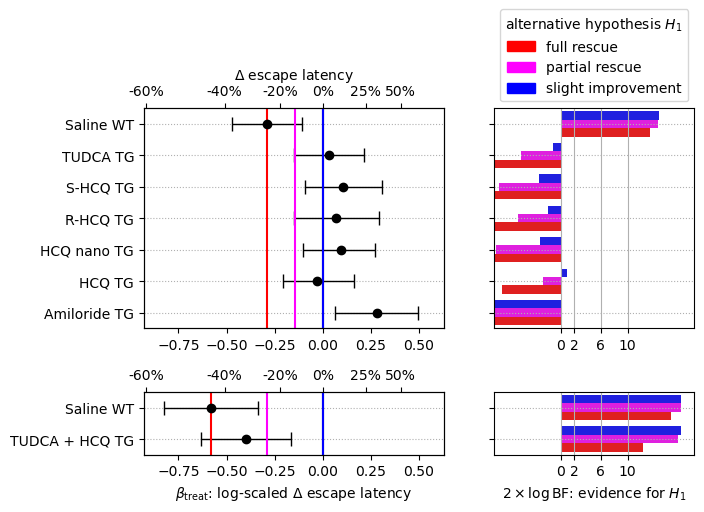

In [45]:
my_palette = ['red', 'magenta', 'blue']
#my_palette = ['black', 'red', 'pink']

def plot_bf_ax(ax, df, exper, do_legend=False):
    BF = df.xs(exper, level=0, axis=0).xs('2 log BF', level=1, axis=1).copy()
    H1_labels = BF.columns.to_list()
    BF = BF.stack().to_frame('2 log BF')
    BF['treatment'] = BF.index.get_level_values(0)
    BF['H1'] = BF.index.get_level_values(1)
    palette = my_palette
    sns.barplot(data=BF, x='2 log BF', y='treatment', hue='H1', ax=ax, palette=palette)
    ax.set_xlabel(r'$2 \times \log \mathrm{BF}$: evidence for $H_1$')
    evidence_l = ['nonexistent', 'negligible', 'moderate', 'strong', 'very strong']
    xticks_major = [0, 2, 6, 10]
    xticks_minor = [-2, 1, 4, 8, 12]
    ax.set_xticks(xticks_major, minor=False)
    #ax.set_xticks(xticks_minor, minor=True)
    xticklabels_minor = len(xticks_minor) * ['']
    ax.grid(axis='both')
    for x, evidence in zip(xticks_minor, evidence_l):
        pass
        #ax.text(x=x, y=0.5, s=evidence, horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=10)
    ax.legend_.remove()
    if do_legend:
        handles = [Patch(color=c) for c in palette]
        ax.legend(handles, H1_labels, bbox_to_anchor=(0.5, 1), loc='lower center', title=r'alternative hypothesis $H_1$')
    return(ax)


def plot_ci_bf(BF_all, experl=exper_list, fullfx_lvls=fullfx_lvls, ref_lvls=ref_lvls):
    height_ratios = [BF_all.xs(e, level=0, axis=0).shape[0] for e in experl]
    width_ratios = [3, 2]
    gridspec_kw = {'left': 0.05, 'right': 0.48, 'hspace': sum(height_ratios) / 20}
    figsize = (12.8, sum(height_ratios) / 2)
    fig, ax = plt.subplots(len(experl), 2, height_ratios=height_ratios, width_ratios=width_ratios, figsize=figsize, gridspec_kw=gridspec_kw)
    Z = zip(experl, fullfx_lvls, ref_lvls)
    for i, t in enumerate(Z):
        exper, fullfx_lvl, ref_lvl = t
        df = BF_all.xs(exper, level=0, axis=0, drop_level=False)
        df_latency = df.xs('log change of escape latency', level=0, axis=1)
        ax_left = ax[i, 0]
        ax_left, ax_left_twin = plot_ci_ax(ax_left, df_latency, exper, ref_lvl=ref_lvl, do_set_axlim=False)
        x_min = -0.8
        x_max = 0.5
        ax_left, ax_left_twin = set_axlim(ax_left, ax_left_twin, x_min, x_max)
        ax_left.set_title('')
        df_t1 = df.xs('t1', level=1, axis=1)
        hypotheses = ['full rescue', 'partial rescue', 'slight improvement']
        palette = my_palette
        t1s = [df_t1[h].iloc[0] for h in hypotheses]
        [ax_left.axvline(t1, color=c) for t1, c in zip(t1s, palette)]
        ax_right = ax[i, 1]
        do_legend = True if i==0 else False
        ax_right = plot_bf_ax(ax_right, BF_all, exper, do_legend=do_legend)
        x2_min = -10
        x2_max = 20
        ax_right.set_xlim(x2_min, x2_max)
        ax_right.set_ylim(ax_right.get_ylim()[1], ax_right.get_ylim()[0])
        ax_right.set_yticklabels([])
        ax_right.set_ylabel('')
        ax_right.grid(linestyle='dotted', axis='y')
        if i > 0:
            ax_left_twin.set_xlabel('')
        if i < len(experl) - 1:
            ax_left.set_xlabel('')
            ax_right.set_xlabel('')
    return((fig, ax))

fig, ax = plot_ci_bf(BF_all, experl=exper_list[1:3], fullfx_lvls=fullfx_lvls[1:3], ref_lvls=ref_lvls[1:3])
attila_utils.savefig(fig, 'CI-BF-TUDCA-HCQ-HCQ-analogs')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/CI-BF-TUDCA-HCQ-HCQ-analogs_m.png',
 'named-figure/CI-BF-TUDCA-HCQ-HCQ-analogs_m.pdf']

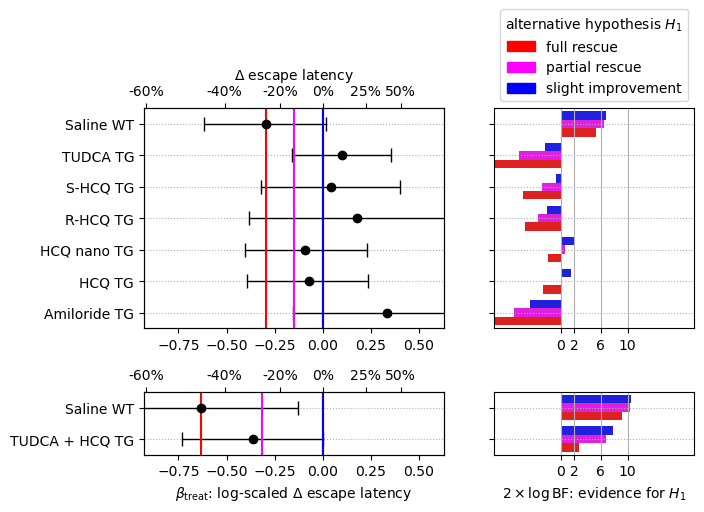

In [46]:
fig, ax = plot_ci_bf(BF_all_m, experl=exper_list[1:3], fullfx_lvls=fullfx_lvls[1:3], ref_lvls=ref_lvls[1:3])
attila_utils.savefig(fig, 'CI-BF-TUDCA-HCQ-HCQ-analogs_m')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/CI-BF-TUDCA-HCQ.png', 'named-figure/CI-BF-TUDCA-HCQ.pdf']

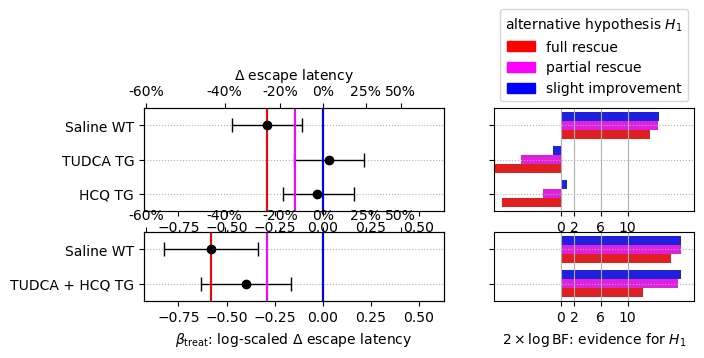

In [47]:
exper_list = ['Amiloride 10 TG', 'CO28152 TG', 'TUDCA + HCQ TG', 'Arundine TG']

BF_TUDCA_HCQ = BF_all.loc[[
    ('CO28152 TG', 'HCQ TG'),
    ('CO28152 TG', 'TUDCA TG'),
    ('CO28152 TG', 'Saline WT'),
    ('TUDCA + HCQ TG', 'TUDCA + HCQ TG'),
    ('TUDCA + HCQ TG', 'Saline WT'),
]]
fig, ax = plot_ci_bf(BF_TUDCA_HCQ, experl=exper_list[1:3], fullfx_lvls=fullfx_lvls[1:3], ref_lvls=ref_lvls[1:3])
attila_utils.savefig(fig, 'CI-BF-TUDCA-HCQ')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/CI-BF-TUDCA-HCQ-anonym.png',
 'named-figure/CI-BF-TUDCA-HCQ-anonym.pdf']

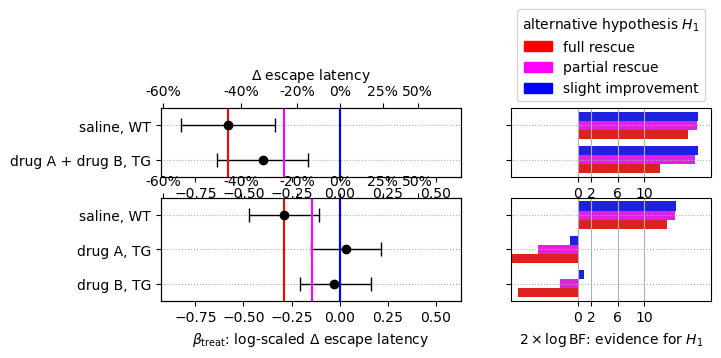

In [48]:
BF_TUDCA_HCQ = BF_all.loc[[
    ('TUDCA + HCQ TG', 'TUDCA + HCQ TG'),
    ('TUDCA + HCQ TG', 'Saline WT'),
    ('CO28152 TG', 'HCQ TG'),
    ('CO28152 TG', 'TUDCA TG'),
    ('CO28152 TG', 'Saline WT'),
]]
fig, ax = plot_ci_bf(BF_TUDCA_HCQ, experl=['TUDCA + HCQ TG', 'CO28152 TG'], fullfx_lvls=['Saline WT', 'Saline WT'], ref_lvls=['Saline WT', 'Saline WT'])
ax[0, 0].set_yticklabels(['drug A + drug B, TG', 'saline, WT'])
ax[1, 0].set_yticklabels(['drug B, TG', 'drug A, TG', 'saline, WT'])
attila_utils.savefig(fig, 'CI-BF-TUDCA-HCQ-anonym')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/CI-BF-TUDCA-HCQ_m.png', 'named-figure/CI-BF-TUDCA-HCQ_m.pdf']

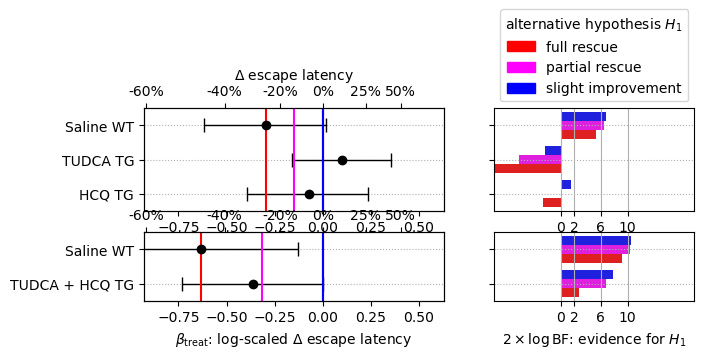

In [49]:
BF_TUDCA_HCQ_m = BF_all_m.loc[[
    ('CO28152 TG', 'HCQ TG'),
    ('CO28152 TG', 'TUDCA TG'),
    ('CO28152 TG', 'Saline WT'),
    ('TUDCA + HCQ TG', 'TUDCA + HCQ TG'),
    ('TUDCA + HCQ TG', 'Saline WT'),
]]
fig, ax = plot_ci_bf(BF_TUDCA_HCQ_m, experl=exper_list[1:3], fullfx_lvls=fullfx_lvls[1:3], ref_lvls=ref_lvls[1:3])
attila_utils.savefig(fig, 'CI-BF-TUDCA-HCQ_m')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/CI-BF-others.png', 'named-figure/CI-BF-others.pdf']

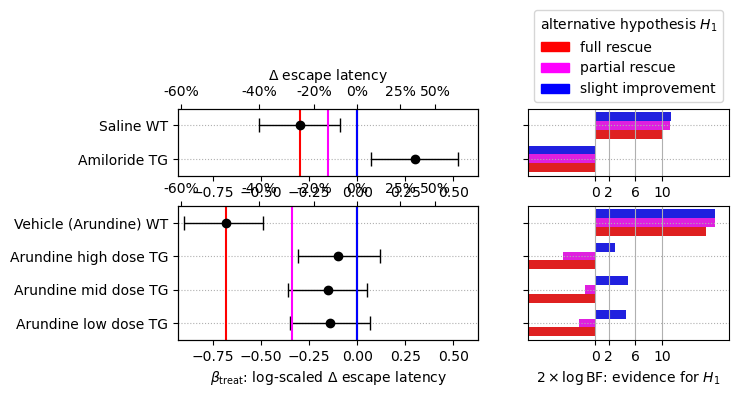

In [50]:
exper_list1 = ['Amiloride 10 TG', 'Arundine TG']
fullfx_lvls1 = ['Saline WT', 'Vehicle (Arundine) WT']
ref_lvls1 = ['Saline TG', 'Vehicle (Arundine) TG']

fig, ax = plot_ci_bf(BF_all, experl=exper_list1, fullfx_lvls=fullfx_lvls1, ref_lvls=ref_lvls1)
attila_utils.savefig(fig, 'CI-BF-others')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

['named-figure/CI-BF-all.png', 'named-figure/CI-BF-all.pdf']

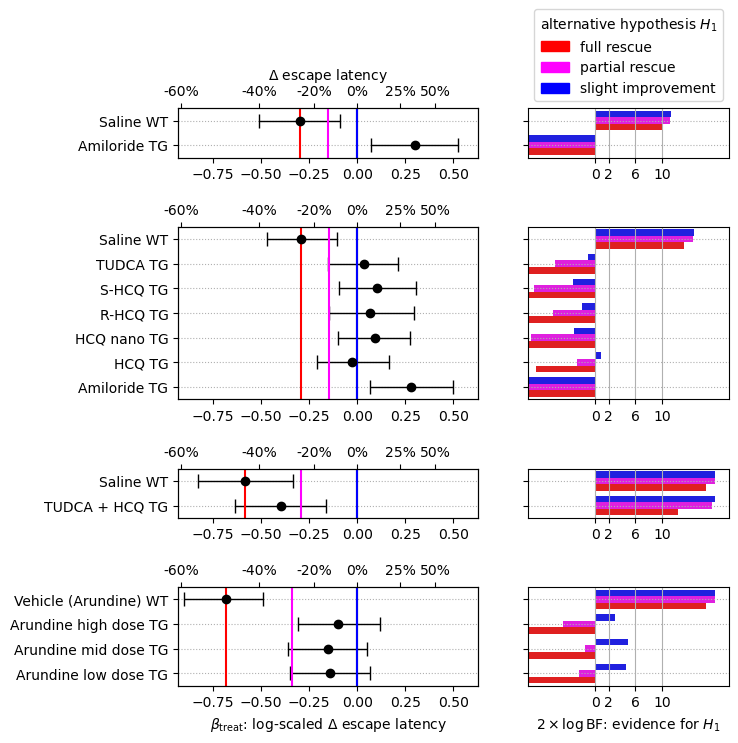

In [51]:
fig, ax = plot_ci_bf(BF_all)
attila_utils.savefig(fig, 'CI-BF-all')

### Study CO26990

0.8


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO26990-Amiloride-10-TG.png',
 'named-figure/learning-rate-effect-CO26990-Amiloride-10-TG.pdf']

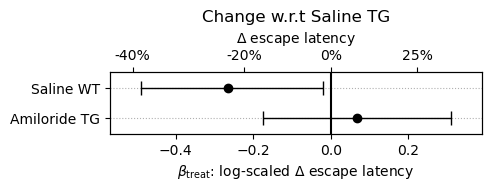

In [52]:
fig, ax = plot_ci(idatas3_CO26990, 'Amiloride 10 TG', 'Saline TG')
attila_utils.savefig(fig, 'learning-rate-effect-CO26990-Amiloride-10-TG')

In [53]:
get_summary(idatas3_CO26990, False)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
Amiloride 10 TG alpha        2.833  0.227     2.377      3.275      0.004   
                Intercept    4.527  0.125     4.274      4.757      0.003   
                Day         -0.292  0.031    -0.352     -0.233      0.001   
                1|IRN_sigma  0.248  0.056     0.138      0.362      0.002   

                             mcse_sd  ess_bulk  ess_tail  r_hat  mean %change  \
Amiloride 10 TG alpha          0.003    2851.0    2614.0    1.0   1599.637354   
                Intercept      0.002    1653.0    1995.0    1.0   9148.070240   
                Day            0.000    2984.0    3037.0    1.0    -25.323146   
                1|IRN_sigma    0.001    1144.0    1104.0    1.0     28.145993   

                             hdi_2.5% %change  hdi_97.5% %change  
Amiloride 10 TG alpha              977.253673        2544.322548  
                Intercept         7080.829510       11539.621295  
                Day                -29.671988         -20.784643  
                1|IRN_sigma         14.797555          43.619894

### Study CO28152

3.2


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO28152-all-TG.png',
 'named-figure/learning-rate-effect-CO28152-all-TG.pdf']

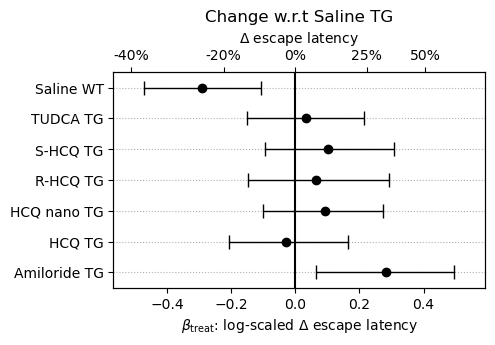

In [54]:
fig, ax = plot_ci(idatas_CO28152, 'CO28152 TG', 'Saline TG')
attila_utils.savefig(fig, 'learning-rate-effect-CO28152-all-TG')

3.2


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO28152-all-WT.png',
 'named-figure/learning-rate-effect-CO28152-all-WT.pdf']

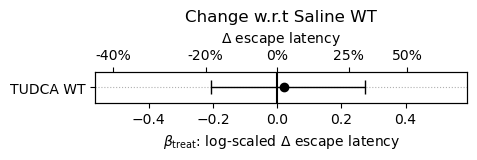

In [55]:
fig, ax = plot_ci(idatas_CO28152, 'CO28152 WT', 'Saline WT')
attila_utils.savefig(fig, 'learning-rate-effect-CO28152-all-WT')

In [56]:
get_summary(idatas_CO28152, False)

mean     sd  hdi_2.5%  hdi_97.5%  \
CO28152 TG Intercept                        4.326  0.079     4.177      4.480   
           Day                             -0.202  0.015    -0.232     -0.174   
           censored(Latency, Status)_alpha  3.673  0.180     3.339      4.041   
           1|IRN_sigma                      0.216  0.026     0.165      0.267   
CO28152 WT Intercept                        4.149  0.110     3.941      4.369   
           Day                             -0.255  0.029    -0.308     -0.195   
           censored(Latency, Status)_alpha  3.095  0.268     2.581      3.624   
           1|IRN_sigma                      0.275  0.056     0.175      0.389   

                                            mcse_mean  mcse_sd  ess_bulk  \
CO28152 TG Intercept                            0.003    0.002     999.0   
           Day                                  0.000    0.000    3315.0   
           censored(Latency, Status)_alpha      0.003    0.002    3038.0   
           1|IRN_sigma                          0.001    0.001    1241.0   
CO28152 WT Intercept                            0.002    0.002    2022.0   
           Day                                  0.000    0.000    3920.0   
           censored(Latency, Status)_alpha      0.004    0.003    3646.0   
           1|IRN_sigma                          0.001    0.001    1474.0   

                                            ess_tail  r_hat  mean %change  \
CO28152 TG Intercept                          1417.0    1.0   7464.111617   
           Day                                2941.0    1.0    -18.290507   
           censored(Latency, Status)_alpha    3153.0    1.0   3836.983839   
           1|IRN_sigma                        2144.0    1.0     24.110238   
CO28152 WT Intercept                          2585.0    1.0   6237.059800   
           Day                                3089.0    1.0    -22.508350   
           censored(Latency, Status)_alpha    2507.0    1.0   2108.723854   
           1|IRN_sigma                        2215.0    1.0     31.653067   

                                            hdi_2.5% %change  \
CO28152 TG Intercept                             6417.004951   
           Day                                    -20.705388   
           censored(Latency, Status)_alpha       2719.092168   
           1|IRN_sigma                             17.939312   
CO28152 WT Intercept                             5047.004562   
           Day                                    -26.508468   
           censored(Latency, Status)_alpha       1221.034190   
           1|IRN_sigma                             19.124622   

                                            hdi_97.5% %change  
CO28152 TG Intercept                              8723.467268  
           Day                                     -15.970310  
           censored(Latency, Status)_alpha        5588.319757  
           1|IRN_sigma                              30.604045  
CO28152 WT Intercept                              7796.462758  
           Day                                     -17.716534  
           censored(Latency, Status)_alpha        3648.721719  
           1|IRN_sigma                              47.550455

### Study CO28154

3.2


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO28154-HCQ_TUDCA-TG.png',
 'named-figure/learning-rate-effect-CO28154-HCQ_TUDCA-TG.pdf']

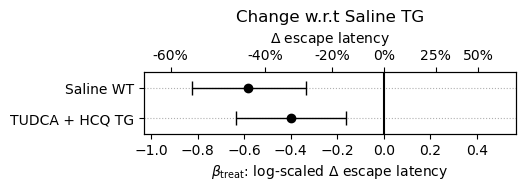

In [57]:
fig, ax = plot_ci(idatas_CO28154, 'TUDCA + HCQ TG', 'Saline TG')
attila_utils.savefig(fig, 'learning-rate-effect-CO28154-HCQ_TUDCA-TG')

3.2


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO28154-Arundine-TG.png',
 'named-figure/learning-rate-effect-CO28154-Arundine-TG.pdf']

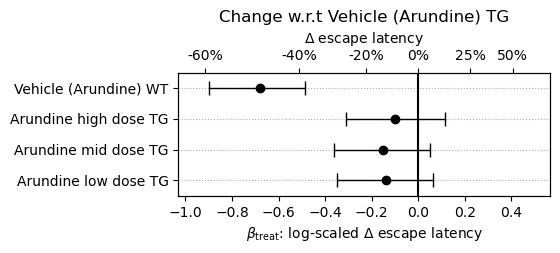

In [58]:
fig, ax = plot_ci(idatas_CO28154, 'Arundine TG', 'Vehicle (Arundine) TG')
attila_utils.savefig(fig, 'learning-rate-effect-CO28154-Arundine-TG')

3.2


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO28154-HCQ_TUDCA-WT.png',
 'named-figure/learning-rate-effect-CO28154-HCQ_TUDCA-WT.pdf']

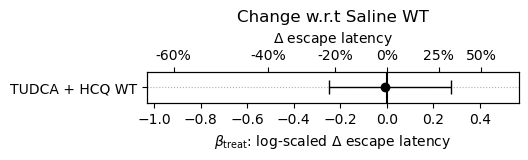

In [59]:
fig, ax = plot_ci(idatas_CO28154, 'TUDCA + HCQ WT', 'Saline WT')
attila_utils.savefig(fig, 'learning-rate-effect-CO28154-HCQ_TUDCA-WT')

3.2


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_91296/986374169.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df.index


['named-figure/learning-rate-effect-CO28154-Arundine-WT.png',
 'named-figure/learning-rate-effect-CO28154-Arundine-WT.pdf']

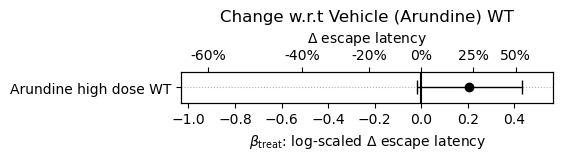

In [60]:
fig, ax = plot_ci(idatas_CO28154, 'Arundine WT', 'Vehicle (Arundine) WT')
attila_utils.savefig(fig, 'learning-rate-effect-CO28154-Arundine-WT')

In [61]:
get_summary(idatas_CO28154, treatment=False)

mean     sd  hdi_2.5%  \
TUDCA + HCQ TG Intercept                        4.776  0.118     4.543   
               Day                             -0.325  0.026    -0.377   
               censored(Latency, Status)_alpha  2.892  0.210     2.476   
               1|IRN_sigma                      0.268  0.049     0.173   
Arundine TG    Intercept                        4.587  0.098     4.402   
               Day                             -0.241  0.021    -0.285   
               censored(Latency, Status)_alpha  3.147  0.186     2.794   
               1|IRN_sigma                      0.220  0.036     0.153   
TUDCA + HCQ WT Intercept                        4.396  0.140     4.144   
               Day                             -0.406  0.034    -0.473   
               censored(Latency, Status)_alpha  2.528  0.215     2.117   
               1|IRN_sigma                      0.324  0.066     0.197   
Arundine WT    Intercept                        4.137  0.113     3.930   
               Day                             -0.352  0.033    -0.420   
               censored(Latency, Status)_alpha  2.815  0.241     2.322   
               1|IRN_sigma                      0.256  0.058     0.150   

                                                hdi_97.5%  mcse_mean  mcse_sd  \
TUDCA + HCQ TG Intercept                            5.006      0.003    0.002   
               Day                                 -0.275      0.000    0.000   
               censored(Latency, Status)_alpha      3.287      0.004    0.003   
               1|IRN_sigma                          0.366      0.001    0.001   
Arundine TG    Intercept                            4.777      0.003    0.002   
               Day                                 -0.203      0.000    0.000   
               censored(Latency, Status)_alpha      3.509      0.003    0.002   
               1|IRN_sigma                          0.294      0.001    0.001   
TUDCA + HCQ WT Intercept                            4.689      0.003    0.002   
               Day                                 -0.339      0.001    0.000   
               censored(Latency, Status)_alpha      2.947      0.004    0.003   
               1|IRN_sigma                          0.449      0.002    0.001   
Arundine WT    Intercept                            4.374      0.002    0.002   
               Day                                 -0.291      0.001    0.000   
               censored(Latency, Status)_alpha      3.273      0.004    0.003   
               1|IRN_sigma                          0.374      0.002    0.001   

                                                ess_bulk  ess_tail  r_hat  \
TUDCA + HCQ TG Intercept                          1290.0    2087.0    1.0   
               Day                                3146.0    2747.0    1.0   
               censored(Latency, Status)_alpha    2323.0    3137.0    1.0   
               1|IRN_sigma                        1237.0    1754.0    1.0   
Arundine TG    Intercept                          1089.0    1775.0    1.0   
               Day                                2832.0    2714.0    1.0   
               censored(Latency, Status)_alpha    3345.0    2833.0    1.0   
               1|IRN_sigma                        1341.0    2090.0    1.0   
TUDCA + HCQ WT Intercept                          1753.0    2030.0    1.0   
               Day                                3170.0    2933.0    1.0   
               censored(Latency, Status)_alpha    2827.0    2821.0    1.0   
               1|IRN_sigma                        1490.0    2455.0    1.0   
Arundine WT    Intercept                          2474.0    2738.0    1.0   
               Day                                4190.0    3007.0    1.0   
               censored(Latency, Status)_alpha    3843.0    2764.0    1.0   
               1|IRN_sigma                        1550.0    1863.0    1.0   

                                                mean %change  \
TUDCA + HCQ TG Intercept              

In [62]:
%connect_info

{
  "shell_port": 54557,
  "iopub_port": 54558,
  "stdin_port": 54559,
  "control_port": 54561,
  "hb_port": 54560,
  "ip": "127.0.0.1",
  "key": "b287d7e8-c1dee5aa3fffbeb1d2f6ba77",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-06-04-5xfad-behavior-CO28154/2024-06-04-5xfad-behavior-CO28154.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4807a225-d7d0-4439-be70-8c9e20d02bf4.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
